**Packages**

In [112]:
import re
import numpy as np
import seaborn as sns
import spacy

In [113]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


In [114]:
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

In [115]:
import imp

tools = imp.load_source('tools', './lda_tools.py')

**The data set**

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('./cn_items_clean.csv')

In [8]:
df.head()

,item_id,fk_repository_history,pubyear,pubmonth,wos_pubdate_online,item_title,scopus_item_title_non_eng,first_author,doi,pmid,...,fncr_5_years,fncr_all_years,hc_3_years,hc_5_years,hc_all_years,oa_status,oa_url,scopus_oa_licence,abstract,title_lower
0,WOS:000173024600148,19474708,2001,NaN,NaN,Extracting slow subspaces from natural videos ...,NaN,"Kayser, C",NaN,NaN,...,2.503746,0.916440,"{""(\""Computer Science, Artificial Intelligence...","{""(\""Computer Science, Artificial Intelligence...","{""(\""Computer Science, Artificial Intelligence...",NaN,NaN,NaN,"{""Natural videos obtained from a camera mounte...",extracting slow subspaces from natural videos ...
1,WOS:000225749600004,25952386,2004,11.0,NaN,Models of the subthalamic nucleus - The import...,NaN,"Gillies, A",10.1016/j.medengphy.2004.06.003,15564109.0,...,0.616486,0.683756,"{""(\""Engineering, Biomedical\"",0.0)""}","{""(\""Engineering, Biomedical\"",0.0)""}","{""(\""Engineering, Biomedical\"",0.0)""}",NaN,NaN,NaN,"{""A coherent set of models is presented that p...",models of the subthalamic nucleus - the import...
2,WOS:000225975400002,52560831,2005,1.0,NaN,Synaptic and spiking dynamics underlying rewar...,NaN,"Deco, G",10.1093/cercor/bhh103,15238449.0,...,2.263256,1.119644,"{""(Neurosciences,1.0)""}","{""(Neurosciences,1.0)""}","{""(Neurosciences,0.0)""}","{green_submitted,bronze}",NaN,NaN,"{""Cognitive and emotional flexibility involve ...",synaptic and spiking dynamics underlying rewar...
3,WOS:000232166100016,51224037,2005,9.0,NaN,Rapid reshaping of human motor generalization,NaN,"Thoroughman, KA",10.1523/jneurosci.1771-05.2005,16192385.0,...,0.856367,1.360798,"{""(Neurosciences,0.0)""}","{""(Neurosciences,0.0)""}","{""(Neurosciences,0.0)""}","{green_published,bronze,green_submitted}",NaN,NaN,"{""People routinely learn how to manipulate new...",rapid reshaping of human motor generalization
4,WOS:000236717500009,5616690,2006,4.0,NaN,Some insights into computational models of (pa...,NaN,"Suffczynski, P",10.1109/jproc.2006.871773,NaN,...,0.305249,0.229523,"{""(\""Engineering, Electrical & Electronic\"",0....","{""(\""Engineering, Electrical & Electronic\"",0....","{""(\""Engineering, Electrical & Electronic\"",0....",{green_submitted},NaN,NaN,"{""The amount of experimental data concerning p...",some insights into computational models of (pa...


In [9]:
len(df)

1553

In [10]:
#extra = pd.read_csv('../data/new_auction_data.csv', index_col=0)
# Abstracts are already part of my data set

In [11]:
#df = pd.concat([df, extra]) # No need to concat here because abstracts are already part of my data set

In [116]:
data = df[['abstract', 'item_id', 'title_lower', 'pubyear']]

In [117]:
data = data.drop_duplicates() # Should ot change anything since dataset is already cleaned

In [118]:
data = data.reset_index(drop=True)

In [119]:
#Add another column with combined title and abstract
data['title_abs'] = data['title_lower'] + " " + data['abstract']
data['title_abs'] = data['title_abs'].str.replace("{", "").str.replace("}", "") # Remove curly brackets

In [16]:
#pd.set_option('display.max_colwidth', None)

data.head()

,abstract,item_id,title_lower,pubyear,title_abs
0,"{""Natural videos obtained from a camera mounte...",WOS:000173024600148,extracting slow subspaces from natural videos ...,2001,extracting slow subspaces from natural videos ...
1,"{""A coherent set of models is presented that p...",WOS:000225749600004,models of the subthalamic nucleus - the import...,2004,models of the subthalamic nucleus - the import...
2,"{""Cognitive and emotional flexibility involve ...",WOS:000225975400002,synaptic and spiking dynamics underlying rewar...,2005,synaptic and spiking dynamics underlying rewar...
3,"{""People routinely learn how to manipulate new...",WOS:000232166100016,rapid reshaping of human motor generalization,2005,rapid reshaping of human motor generalization ...
4,"{""The amount of experimental data concerning p...",WOS:000236717500009,some insights into computational models of (pa...,2006,some insights into computational models of (pa...


In [17]:
data.describe() # what is the ref published in 1000?

,pubyear
count,1553.000000
mean,2014.189955
std,6.562691
min,1991.000000
25%,2010.000000
50%,2016.000000
75%,2019.000000
max,2023.000000


**Sentences to words**

In [18]:
#data['title_lower'] = data['title_lower'].astype(str)

In [120]:
words = list(tools.sentences_to_words(data['title_abs'].values))

In [121]:
# Check if format turned out as expected
print(words[:5])

[['extracting', 'slow', 'subspaces', 'from', 'natural', 'videos', 'leads', 'to', 'complex', 'cells', 'natural', 'videos', 'obtained', 'from', 'camera', 'mounted', 'on', 'cat', 'head', 'axe', 'used', 'as', 'stimuli', 'for', 'network', 'of', 'subspace', 'energy', 'detectors', 'the', 'network', 'is', 'trained', 'by', 'gradient', 'ascent', 'on', 'an', 'objective', 'function', 'defined', 'by', 'the', 'squared', 'temporal', 'derivatives', 'of', 'the', 'cells', 'outputs', 'the', 'resulting', 'receptive', 'fields', 'are', 'invariant', 'to', 'both', 'contrast', 'polarity', 'and', 'translation', 'and', 'thus', 'resemble', 'complex', 'type', 'receptive', 'fields'], ['models', 'of', 'the', 'subthalamic', 'nucleus', 'the', 'importance', 'of', 'intranuclear', 'connectivity', 'coherent', 'set', 'of', 'models', 'is', 'presented', 'that', 'provide', 'novel', 'and', 'testable', 'predictions', 'about', 'the', 'functional', 'role', 'of', 'the', 'subthalamic', 'nucleus', 'stn', 'in', 'the', 'basal', 'gangl

In [122]:
for word_list in words:
    for word in word_list:
        if isinstance(word, int):
            print("Found an integer:", word) # No, all good.

**Cleaning data set**

In [123]:
from nltk.corpus import stopwords
#import nltk
#nltk.download('stopwords')

In [124]:
stop_words = stopwords.words('english')

In [125]:
#print(stop_words)

In [126]:
# Build the bigram and trigram models
# N-grams are just continuos sequences of words
bigram = gensim.models.Phrases(words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [127]:
# lemmatized_words = tools.clean_words(words, bigram, stop_words) # old NG version
lemmatized_words = tools.clean_words(words, stop_words, bigram) # Order had to be changed because of the way the function is written

In [27]:
len(lemmatized_words) # 1553

1553

In [28]:
len(words) # Same, but also in NG version stays the same

1553

In [29]:
print(lemmatized_words[:5]) # looks fine, no flexion of words

[['extract', 'slow', 'subspace', 'natural', 'video', 'lead', 'complex', 'cell', 'natural', 'video', 'obtain', 'camera', 'mount', 'cat', 'head', 'axe', 'use', 'detector', 'network', 'train', 'gradient', 'ascent', 'objective', 'function', 'define', 'squared', 'temporal', 'derivative', 'cell', 'output', 'result', 'receptive', 'field', 'invariant', 'contrast', 'polarity', 'translation', 'thus', 'resemble', 'complex', 'type', 'receptive', 'field'], ['model', 'subthalamic', 'importance', 'intranuclear', 'connectivity', 'coherent', 'set', 'model', 'present', 'provide', 'novel', 'testable', 'prediction', 'functional', 'role', 'subthalamic', 'nucleus', 'stn', 'basal', 'ganglia', 'stn', 'emerge', 'important', 'target', 'novel', 'therapeutic', 'strategy', 'alleviation', 'parkinsonian', 'type', 'symptom', 'computational', 'mathematical', 'model', 'base', 'property', 'stn', 'interaction', 'review', 'model', 'focus', 'core', 'anatomical', 'physiological', 'datum', 'span', 'many', 'level', 'assess', 

**Create corpus**

In [128]:
id2word = corpora.Dictionary(lemmatized_words)

texts = lemmatized_words

corpus = [id2word.doc2bow(text) for text in texts]

**Create model and select number of topics**

In [31]:
#mallet_path = '/Users/storm/rsc/mallet-2.0.8/bin/mallet' # ?????

In [32]:
# Remember to add +1 to the limit because the limit is exclusive
limit = 31 #9 # Adjust according to stabilization of coherence score

In [33]:
#print(gensim.__version__)

In [34]:
#!pip install gensim==3.8.3

In [35]:
# from gensim.models.wrappers import LdaMallet
# Switching to native LDA implementation

In [129]:
from gensim.models import LdaModel, CoherenceModel

In [130]:
def compute_coherence_values_gensim(dictionary, corpus, texts, limit, start=2, step=2): # Needed to be rewritten
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence="c_v")
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [131]:
model_list, coherence_values = compute_coherence_values_gensim(id2word, corpus, lemmatized_words, limit=limit, start=2, step=1) # takes about 10 minutes

In [39]:
# Old version, needs mallet
# model_list, coherence_values = tools.compute_coherence_values(limit=limit,
#                                                              step=1,
#                                                              mallet_path=mallet_path,
#                                                              dictionary=id2word,
#                                                              corpus=corpus,
#                                                              texts=lemmatized_words)

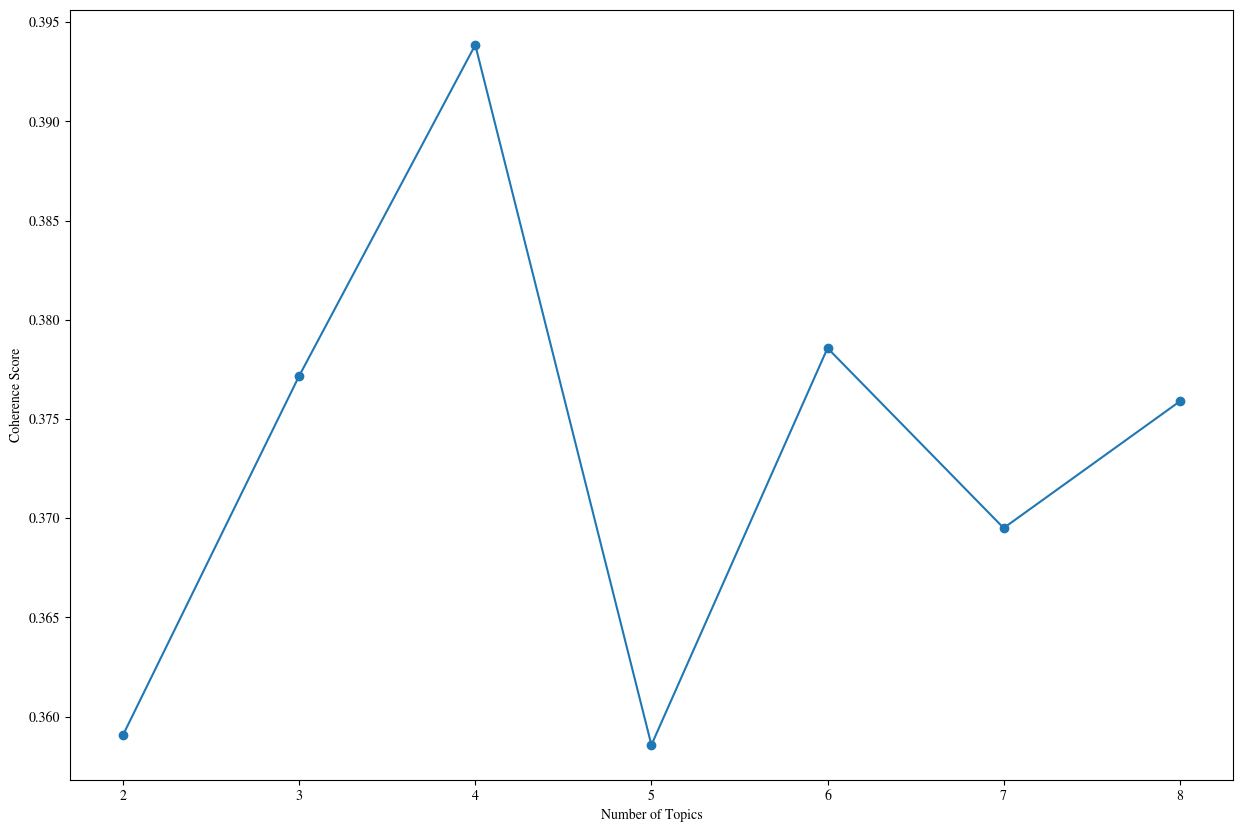

In [134]:
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'Computer Modern Roman'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

#fig = plt.subplots()
plt.figure(figsize=(15, 10))
num_of_topics = range(2, limit, 1) # Start with two at least, makes no sense otherwise
plt.plot(num_of_topics, coherence_values, '-o')

plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

In [135]:
for num, cv in zip(num_of_topics, coherence_values):
    print("Num Topics =", num, " has Coherence Value of", round(cv, 4)) # 4 for 4 digits

Num Topics = 2  has Coherence Value of 0.3591
Num Topics = 3  has Coherence Value of 0.3772
Num Topics = 4  has Coherence Value of 0.3939
Num Topics = 5  has Coherence Value of 0.3586
Num Topics = 6  has Coherence Value of 0.3786
Num Topics = 7  has Coherence Value of 0.3695
Num Topics = 8  has Coherence Value of 0.3759


In [148]:
max_coherence_value = max(coherence_values)
max_index = coherence_values.index(max_coherence_value) # the number of topics will be where there is the highest coherence value

In [149]:
num_of_topics[max_index]

4

Find the averaged optimal number of topics

In [150]:
# Redefine compute_coherence_values_gensim to be able to pass different seeds
def compute_coherence_values_gensim_seed(dictionary, corpus, texts, limit, start=2, step=2, seed=0): 
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=seed, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence="c_v")
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [151]:
# set parameters:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # Define seeds to be used # Lessen if too slow
all_coherence_values = [] # For list of lists of coherence values
start = 2
step = 1

In [152]:
seeds

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Attention, the next step is taking ages to run! Outcommented since this step has been done and I am just importing the results.

In [153]:
#for seed in seeds: # function compute_coherence_values_gensim is called with the current seed value
#    _, coherence_values = compute_coherence_values_gensim_seed(id2word, corpus, lemmatized_words, limit, start, step, seed)
#   #_ is a placeholder for model_list, which is not needed here
#    all_coherence_values.append(coherence_values)

In [48]:
#data_seeds = []
#for i, num_topics in enumerate(range(start, limit, step)):
#    for seed_index, seed in enumerate(seeds):
#        data_seeds.append({
#            'Number of Topics': num_topics,
#            'Coherence Value': all_coherence_values[seed_index][i],
#            'Seed': seed
#        })

In [49]:
#df_seeds = pd.DataFrame(data_seeds)
#df_seeds.to_csv("df_lda_seeds.csv", index=False) # So I don't have to run it again everytime

In [154]:
# Activate if the script needs to run but no time to wait for it to run through all seeds
df_seeds = pd.read_csv("df_lda_seeds.csv")

plt.figure(figsize=(15, 10))
sns.violinplot(x='Number of Topics', y='Coherence Value', data=df_seeds, fill=False)
#sns.swarmplot(x='Number of Topics', y='Coherence Value', data=df_seeds, color='k', alpha=0.5)
plt.title('Distribution of Coherence Values')
plt.show()

c:\Users\kleinow\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kleinow\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kleinow\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kleinow\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

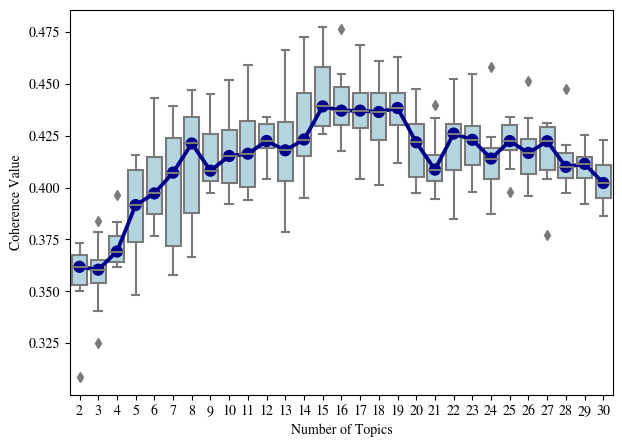

In [155]:
plt.figure(figsize=(9,5 ))

sns.boxplot(x='Number of Topics', y='Coherence Value', data=df_seeds, color='lightblue')

# Overlaying a pointplot for the medians in dark blue
sns.pointplot(x='Number of Topics', y='Coherence Value', data=df_seeds, estimator=np.median, join=True, color='darkblue', ci=None)
plt.savefig('lda_bestseed.pdf')  
#plt.title('Distribution of Coherence Values') # Not needed for use in thesis
plt.show()

# Rainbow version of the above
plt.figure(figsize=(15, 10))

# Set the colorblind-friendly palette for the plots
sns.set_palette("colorblind")

# Using a boxplot for the distribution
sns.boxplot(x='Number of Topics', y='Coherence Value', data=df_seeds)

# Overlaying a pointplot for the means with a contrasting color
sns.pointplot(x='Number of Topics', y='Coherence Value', data=df_seeds, estimator=np.mean, join=True, color='darkblue')

#plt.title('Distribution of Coherence Values') # Added in Figure description
plt.show()

In [52]:
average_coherences = df_seeds.groupby('Number of Topics')['Coherence Value'].mean()


best_num_topics = average_coherences.idxmax()
highest_avg_coherence = average_coherences.max()
highest_avg_coherence # 0.44602461359382495
#best_num_topics # 15!!

0.44602461359382495

In [53]:
# Retrieve seed that produced the highest coherence score for 15 topics
#df_15_topics = df_seeds[df_seeds['Number of Topics'] == 15]
df_8_topics = df_seeds[df_seeds['Number of Topics'] == 8]

#best_seed = df_15_topics[df_15_topics['Coherence Value'] == df_15_topics['Coherence Value'].max()]['Seed'].values[0]
best_seed = df_8_topics[df_8_topics['Coherence Value'] == df_8_topics['Coherence Value'].max()]['Seed'].values[0]
best_seed # 9 # 5


5

**Model for num topics = 15 with seed = 9**

In [54]:
# Adjust limit after having found the best number of topics
limit = 8+1 # best_num_topics + 1

In [55]:
model_list, coherence_values = compute_coherence_values_gensim_seed(id2word, corpus, lemmatized_words, limit=limit, start=2, step=1, seed=best_seed) # takes about 10 minutes
# take care of the limit + 1 because range is exclusive!!!

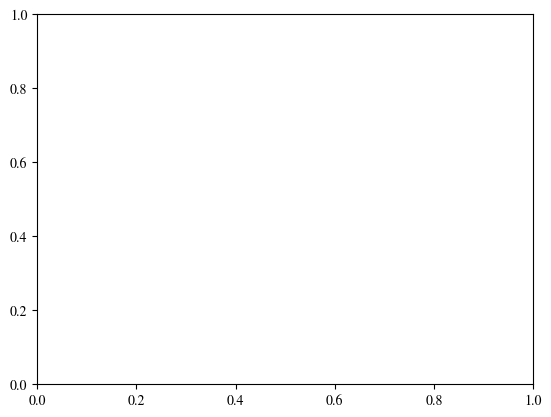

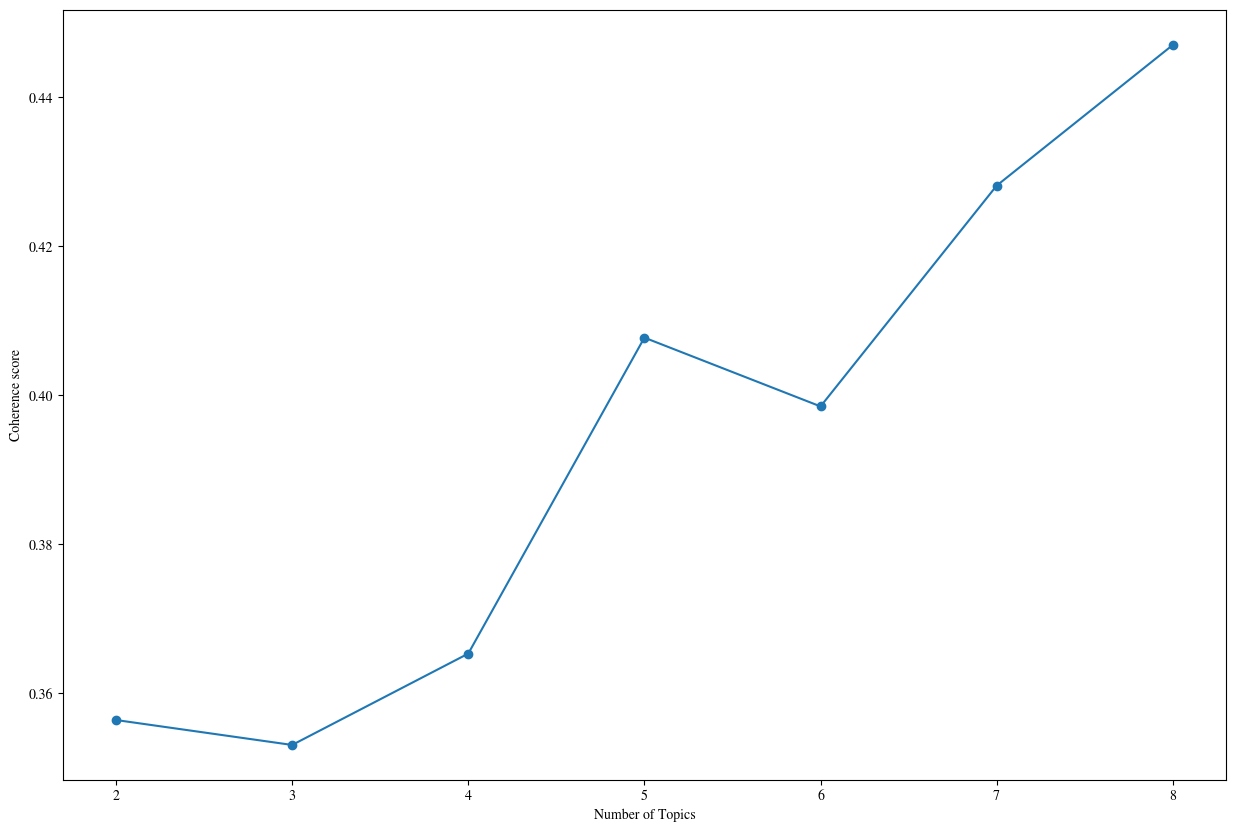

In [56]:
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'Computer Modern Roman'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

fig = plt.subplots()
plt.figure(figsize=(15, 10))
num_of_topics = range(2, limit, 1) # Start with two at least, makes no sense otherwise
plt.plot(num_of_topics, coherence_values, '-o')

plt.xlabel("Number of Topics")
plt.ylabel("Coherence score");

In [57]:
for num, cv in zip(num_of_topics, coherence_values):
    print("Num Topics =", num, " has Coherence Value of", round(cv, 4)) # get this to a proper table

Num Topics = 2  has Coherence Value of 0.3564
Num Topics = 3  has Coherence Value of 0.3531
Num Topics = 4  has Coherence Value of 0.3653
Num Topics = 5  has Coherence Value of 0.4078
Num Topics = 6  has Coherence Value of 0.3985
Num Topics = 7  has Coherence Value of 0.4282
Num Topics = 8  has Coherence Value of 0.447


In [58]:
max_coherence_value = max(coherence_values)
max_index = coherence_values.index(max_coherence_value)

In [59]:
num_of_topics[max_index]

8

In [60]:
optimal_model = model_list[max_index]
model_topics = optimal_model.show_topics(formatted=False)

In [61]:
len(model_list)

7

for topic in range(model.num_topics): # too little data, looks bad
    plt.figure(figsize=(15, 7))
    sns.violinplot(data=df_contributions, x="pubyear", y=topic, inner="quart")
    plt.title(f"Topic {topic+1} Contribution Over the Years")
    plt.ylabel("Contribution (%)")
    plt.show()

In [62]:
model_topics

[(0,
  [('disorder', 0.03491887),
   ('psychiatry', 0.026610674),
   ('pipeline', 0.023760648),
   ('decomposition', 0.021746274),
   ('tensor', 0.019848047),
   ('mental', 0.018920653),
   ('coordination', 0.014266069),
   ('psychiatric', 0.01349132),
   ('substantial', 0.011768592),
   ('advanced', 0.0111957565)]),
 (1,
  [('brain', 0.03191794),
   ('datum', 0.018811379),
   ('neuroscience', 0.016665788),
   ('computational', 0.013855568),
   ('tool', 0.013541499),
   ('research', 0.013496948),
   ('use', 0.012933367),
   ('new', 0.010309112),
   ('development', 0.009509089),
   ('analysis', 0.009475887)]),
 (2,
  [('potential', 0.03228379),
   ('temperature', 0.025951019),
   ('extracellular', 0.018643362),
   ('membrane', 0.017110553),
   ('nerve', 0.015921682),
   ('case', 0.013092657),
   ('current', 0.013063708),
   ('intracellular', 0.011897101),
   ('cable', 0.0114784725),
   ('flow', 0.011265654)]),
 (3,
  [('network', 0.041285947),
   ('model', 0.028918985),
   ('neural', 0.

**Assign Documents to Topic**

def format_topics_sentences(ldamodel, corpus, data_frame):
    data_with_topics = pd.DataFrame(columns= ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']) # df has to be defined here already

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)  # Adjusting this line to account for Gensim's output structure
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                # Change the appending line
                data_with_topics.loc[i] = [int(topic_num), round(prop_topic, 4), topic_keywords]
            else:
                break

    

    data_with_topics = pd.concat([data_with_topics, data_frame.reset_index(drop=True)], axis=1)
    return data_with_topics

In [63]:
# Rewritten function: Removed internal for loop; max() function to directly get the dominant topic for each row;
# topic data in a list and later converted to a dataframe, seems to be more efficient than appending rows after rows

def format_topics_sentences(ldamodel, corpus, data_frame):
    topics_data = []

    for row in ldamodel[corpus]:
        topic_num, prop_topic = max(row[0], key=lambda x: x[1])
        topic_keywords = ", ".join([word for word, _ in ldamodel.show_topic(topic_num)])
        topics_data.append([int(topic_num), round(prop_topic, 4), topic_keywords])

    data_with_topics = pd.DataFrame(topics_data, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])
    return pd.concat([data_with_topics, data_frame.reset_index(drop=True)], axis=1)

In [64]:
# written for LDA models produced by MALLET that returns a list of tuples where each tuple is (topic_num, proportion)
# native Gensim LDA model returns a different structure for topics
data_with_topics = format_topics_sentences(ldamodel=optimal_model,
                                           corpus=corpus,
                                           data_frame=data)

In [65]:
data_with_topics.head()


,Dominant_Topic,Perc_Contribution,Topic_Keywords,abstract,item_id,title_lower,pubyear,title_abs
0,4,0.3584,"model, spike, neuron, dynamic, activity, signa...","{""Natural videos obtained from a camera mounte...",WOS:000173024600148,extracting slow subspaces from natural videos ...,2001,extracting slow subspaces from natural videos ...
1,6,0.4021,"computational, model, neuroscience, learn, sys...","{""A coherent set of models is presented that p...",WOS:000225749600004,models of the subthalamic nucleus - the import...,2004,models of the subthalamic nucleus - the import...
2,4,0.5725,"model, spike, neuron, dynamic, activity, signa...","{""Cognitive and emotional flexibility involve ...",WOS:000225975400002,synaptic and spiking dynamics underlying rewar...,2005,synaptic and spiking dynamics underlying rewar...
3,6,0.6123,"computational, model, neuroscience, learn, sys...","{""People routinely learn how to manipulate new...",WOS:000232166100016,rapid reshaping of human motor generalization,2005,rapid reshaping of human motor generalization ...
4,6,0.4555,"computational, model, neuroscience, learn, sys...","{""The amount of experimental data concerning p...",WOS:000236717500009,some insights into computational models of (pa...,2006,some insights into computational models of (pa...


In [66]:
data_with_topics

,Dominant_Topic,Perc_Contribution,Topic_Keywords,abstract,item_id,title_lower,pubyear,title_abs
0,4,0.3584,"model, spike, neuron, dynamic, activity, signa...","{""Natural videos obtained from a camera mounte...",WOS:000173024600148,extracting slow subspaces from natural videos ...,2001,extracting slow subspaces from natural videos ...
1,6,0.4021,"computational, model, neuroscience, learn, sys...","{""A coherent set of models is presented that p...",WOS:000225749600004,models of the subthalamic nucleus - the import...,2004,models of the subthalamic nucleus - the import...
2,4,0.5725,"model, spike, neuron, dynamic, activity, signa...","{""Cognitive and emotional flexibility involve ...",WOS:000225975400002,synaptic and spiking dynamics underlying rewar...,2005,synaptic and spiking dynamics underlying rewar...
3,6,0.6123,"computational, model, neuroscience, learn, sys...","{""People routinely learn how to manipulate new...",WOS:000232166100016,rapid reshaping of human motor generalization,2005,rapid reshaping of human motor generalization ...
4,6,0.4555,"computational, model, neuroscience, learn, sys...","{""The amount of experimental data concerning p...",WOS:000236717500009,some insights into computational models of (pa...,2006,some insights into computational models of (pa...
...,...,...,...,...,...,...,...,...
1548,3,0.4151,"network, model, neural, use, simulation, metho...","{""Neuromorphic computing is emerging to be a d...",WOS:000612326000001,on the self-repair role of astrocytes in stdp ...,2021,on the self-repair role of astrocytes in stdp ...
1549,6,0.3547,"computational, model, neuroscience, learn, sys...","{""Mechanistic models of single-neuron dynamics...",WOS:000452649401032,flexible statistical inference for mechanistic...,2017,flexible statistical inference for mechanistic...
1550,6,0.8268,"computational, model, neuroscience, learn, sys...","{""Fueled by developments in computational neur...",WOS:000446411600007,the predictive coding account of psychosis,2018,"the predictive coding account of psychosis ""Fu..."
1551,4,0.5035,"model, spike, neuron, dynamic, activity, signa...","{""Analysis of correlated spike trains is a hot...",WOS:000278530200003,conditional mixture model for correlated neuro...,2010,conditional mixture model for correlated neuro...


**Find the most representative document for each topic**

In [67]:
documents_of_topic = pd.DataFrame()

documents_of_topic_grpd = data_with_topics.groupby('Dominant_Topic')

for i, grp in documents_of_topic_grpd:
    documents_of_topic = pd.concat([documents_of_topic, 
                                    grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                    axis=0)
documents_of_topic.reset_index(drop=True, inplace=True)
documents_of_topic = documents_of_topic[['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords','title_lower', 'pubyear']]

In [68]:
documents_of_topic.values

array([[0, 0.3400999903678894,
        'disorder, psychiatry, pipeline, decomposition, tensor, mental, coordination, psychiatric, substantial, advanced',
        'seasonal variation in collective mood via twitter content and medical purchases',
        2017],
       [1, 0.6518999934196472,
        'brain, datum, neuroscience, computational, tool, research, use, new, development, analysis',
        'exploration and virtual experimentation in a local neuroscience database',
        1995],
       [2, 0.9261999726295471,
        'potential, temperature, extracellular, membrane, nerve, case, current, intracellular, cable, flow',
        'effects of temperature on simulated electrotonic potentials and their current kinetics of human motor axons at 20 degrees c-42 degrees c',
        2014],
       [3, 0.901199996471405,
        'network, model, neural, use, simulation, method, neuron, computational, large, datum',
        'gpu implementation of neural-network simulations based on adaptive-exp

**Stats summary for each topic**

In [69]:
topic_counts = data_with_topics['Dominant_Topic'].value_counts()

topic_contribution = (round(topic_counts/topic_counts.sum(), 4))*100

In [70]:
stats= pd.DataFrame([topic_counts.index+1, # +1 for the actual topic number
                     topic_counts,
                     topic_contribution]).T
stats.columns = ['Dominant_Topic', 'Num of Documents', 'Percentage of Documents']

In [71]:
stats

,Dominant_Topic,Num of Documents,Percentage of Documents
0,7.0,751.0,48.36
1,5.0,384.0,24.73
2,4.0,274.0,17.64
3,2.0,106.0,6.83
4,3.0,25.0,1.61
5,8.0,8.0,0.52
6,6.0,3.0,0.19
7,1.0,2.0,0.13


In [72]:
topic_num_keywords = data_with_topics[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()

df_topics = pd.merge(stats, topic_num_keywords, on='Dominant_Topic')

In [73]:
df_topics['Topic_Keywords'].values

array(['equation, cell, differential, density, excitatory, system, distance, solution, bifurcation, problem',
       'deficit, reward, mechanical, law, damage, dopaminergic, dopamine, fitting, unexpected, chemical',
       'model, spike, neuron, dynamic, activity, signal, neural, use, synaptic, result',
       'potential, temperature, extracellular, membrane, nerve, case, current, intracellular, cable, flow',
       'network, model, neural, use, simulation, method, neuron, computational, large, datum',
       'computational, model, neuroscience, learn, system, brain, approach, cognitive, theory, control',
       'brain, datum, neuroscience, computational, tool, research, use, new, development, analysis'],
      dtype=object)

In [74]:
topic_num_keywords

,Dominant_Topic,Topic_Keywords
0,4,"model, spike, neuron, dynamic, activity, signa..."
1,6,"computational, model, neuroscience, learn, sys..."
7,2,"potential, temperature, extracellular, membran..."
9,3,"network, model, neural, use, simulation, metho..."
23,1,"brain, datum, neuroscience, computational, too..."
68,5,"deficit, reward, mechanical, law, damage, dopa..."
127,7,"equation, cell, differential, density, excitat..."
164,0,"disorder, psychiatry, pipeline, decomposition,..."


**Number of topics per year**

In [75]:
yearly = (
        data_with_topics.groupby(["Dominant_Topic", "pubyear"]).size().reset_index().groupby("pubyear").size()
    )

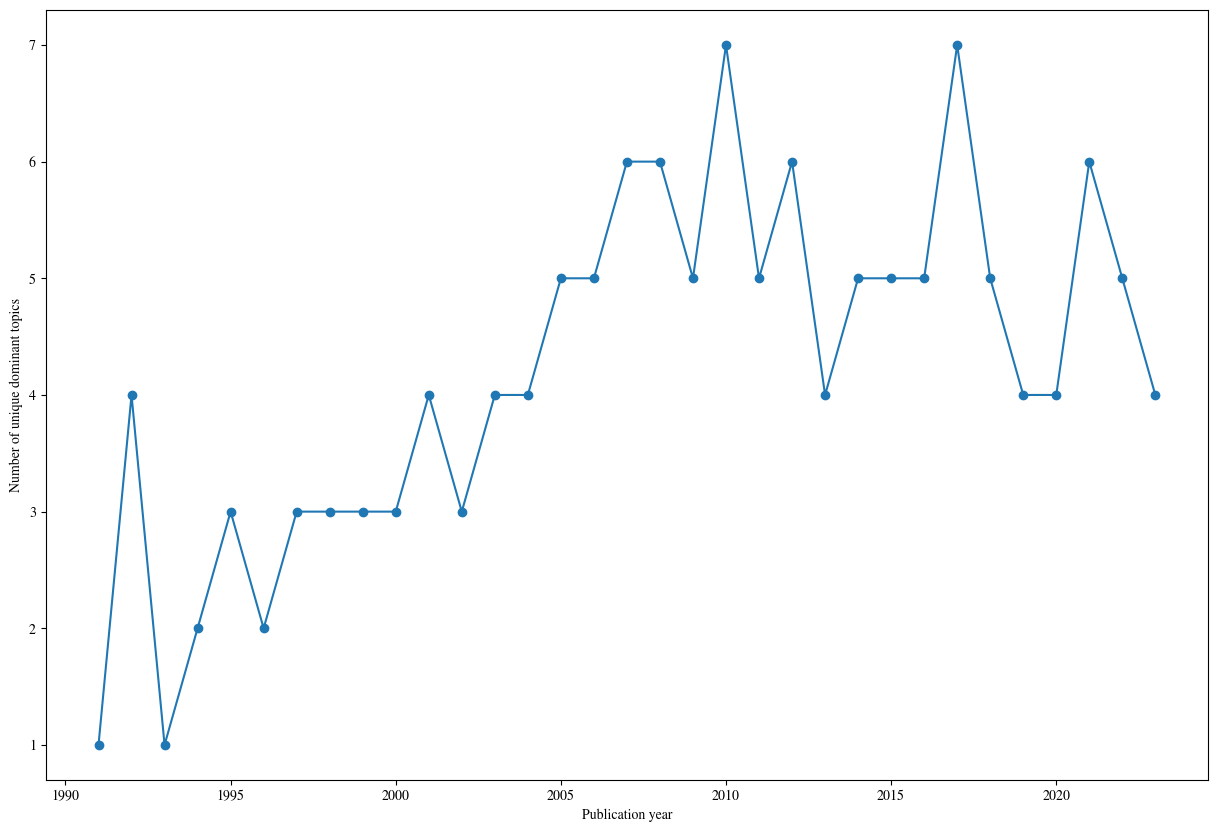

In [76]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(yearly, '-o', label='num of topics')
ax.set_ylabel("Number of unique dominant topics")
ax.set_xlabel("Publication year")

plt.show()

In [77]:
first_row = next(iter(model_list[0][corpus]))
print(first_row)

([(0, 0.55880487), (1, 0.4411951)], [(0, [0, 1]), (1, [0, 1]), (2, [1, 0]), (3, [0]), (4, [0, 1]), (5, [1, 0]), (6, [0, 1]), (7, [0, 1]), (8, [0]), (9, [0, 1]), (10, [0, 1]), (11, [1, 0]), (12, [0, 1]), (13, [0, 1]), (14, [0, 1]), (15, [1, 0]), (16, [0, 1]), (17, [1, 0]), (18, [0, 1]), (19, [1, 0]), (20, [0, 1]), (21, [0, 1]), (22, [0, 1]), (23, [1, 0]), (24, [1, 0]), (25, [0, 1]), (26, [0, 1]), (27, [0, 1]), (28, [0, 1]), (29, [0, 1]), (30, [0, 1]), (31, [0, 1]), (32, [0, 1]), (33, [1, 0]), (34, [0, 1]), (35, [0, 1]), (36, [1, 0])], [(0, [(0, 0.82295686), (1, 0.14098106)]), (1, [(0, 0.82295686), (1, 0.14098106)]), (2, [(0, 0.30454466), (1, 0.69058216)]), (3, [(0, 0.9922626)]), (4, [(0, 1.5313178), (1, 0.46858826)]), (5, [(0, 0.1891585), (1, 1.8106217)]), (6, [(0, 0.77743596), (1, 0.22242342)]), (7, [(0, 0.555622), (1, 0.4442277)]), (8, [(0, 0.99397326)]), (9, [(0, 0.8383148), (1, 0.1533185)]), (10, [(0, 0.5377041), (1, 0.46205547)]), (11, [(0, 0.8062627), (1, 1.1936442)]), (12, [(0, 0

In [78]:

def get_topic_contributions_for_year(model, corpus, data, topic_num=0):
    topic_contributions = []
    
    for i, row_lists in enumerate(model[corpus]):
        row = row_lists[0]  # Get the list of (topic number, topic probability) pairs
        for topic, prob in row:
            if topic == topic_num:
                topic_contributions.append((data.iloc[i]['pubyear'], prob))
                
    return topic_contributions

all_contributions = []
for model in model_list:
    all_contributions.extend(get_topic_contributions_for_year(model, corpus, data))

# Convert to DataFrame for easier plotting
df_contributions = pd.DataFrame(all_contributions, columns=['pubyear', 'contribution'])

#plt.figure(figsize=(15, 7)) # Violin plots are not really practial in this case
#sns.violinplot(x="pubyear", y="contribution", data=df_contributions)
#plt.title("Influence of Topic 1 Over the Years")
#plt.show()


In [79]:
from collections import defaultdict

def compute_document_topic_contribution(model, corpus):
    document_topic_contributions = []
    
    for index, doc in enumerate(corpus):
        total_topic_contrib = defaultdict(float)
        
        for word_id, word_count in doc:
            word_topics = model.get_term_topics(word_id, minimum_probability=0.001)  # minimum_probability can be adjusted if needed
            
            for topic, prob in word_topics:
                total_topic_contrib[topic] += prob * word_count
        # avoid ZeroDivisionError
        try:
            # normalize the contribution to percentage because of rising numbers of documents over the years!!
            total_contrib_percent = {topic: (contrib / sum(total_topic_contrib.values())) * 100 for topic, contrib in total_topic_contrib.items()}
            document_topic_contributions.append(total_contrib_percent)
        
        except ZeroDivisionError:
            print(f"Error for document at index {index}: No topic contributions found.")
            continue
            
    return document_topic_contributions




contributions = compute_document_topic_contribution(model, corpus)




# df for plots
df_contributions = pd.DataFrame(contributions)
df_contributions["pubyear"] = data["pubyear"]

c:\Users\kleinow\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kleinow\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kleinow\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kleinow\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

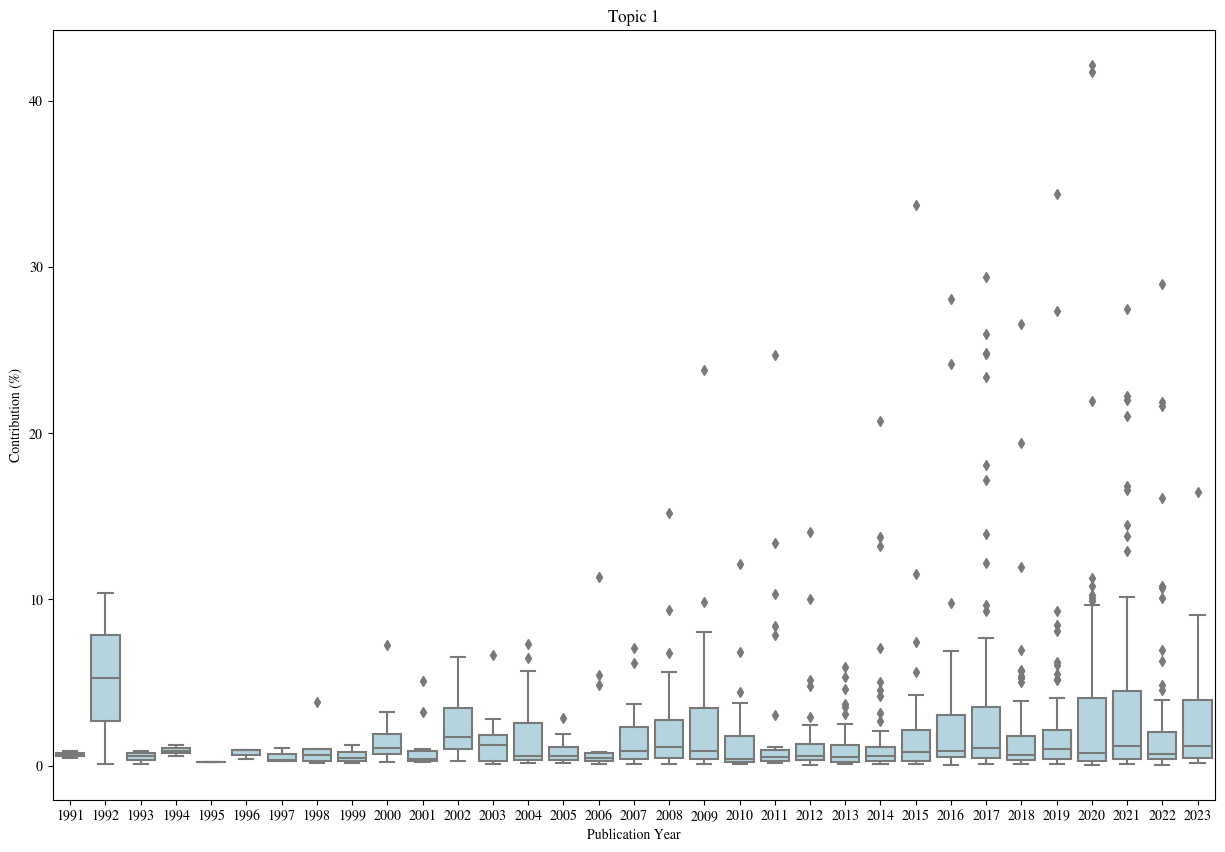

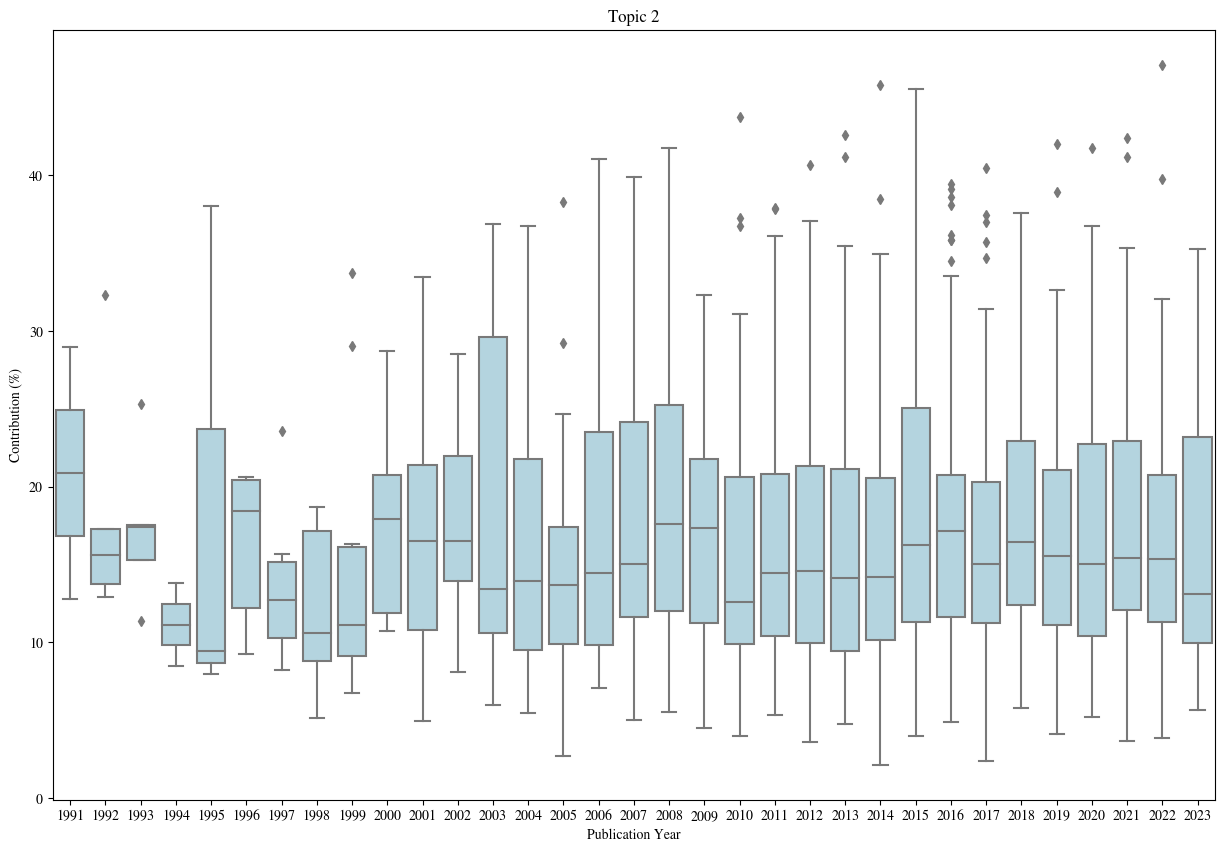

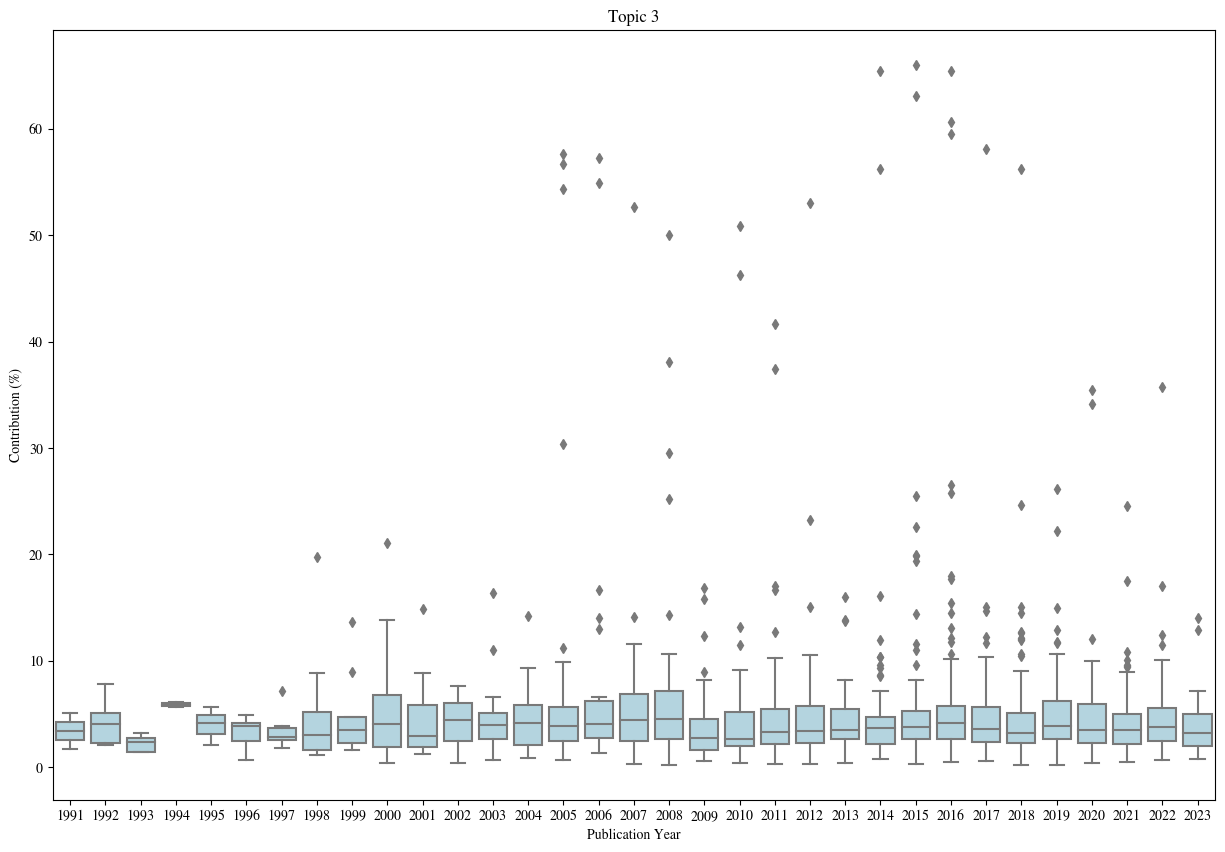

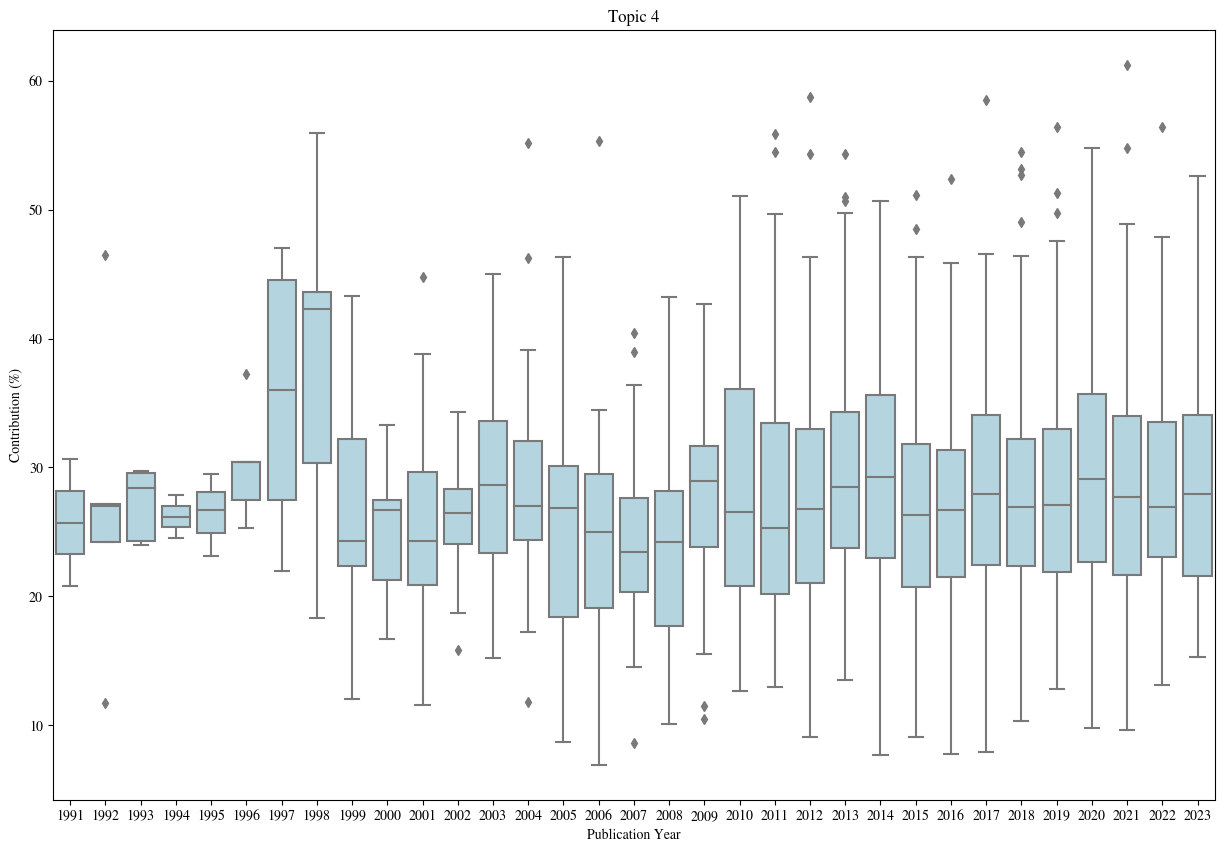

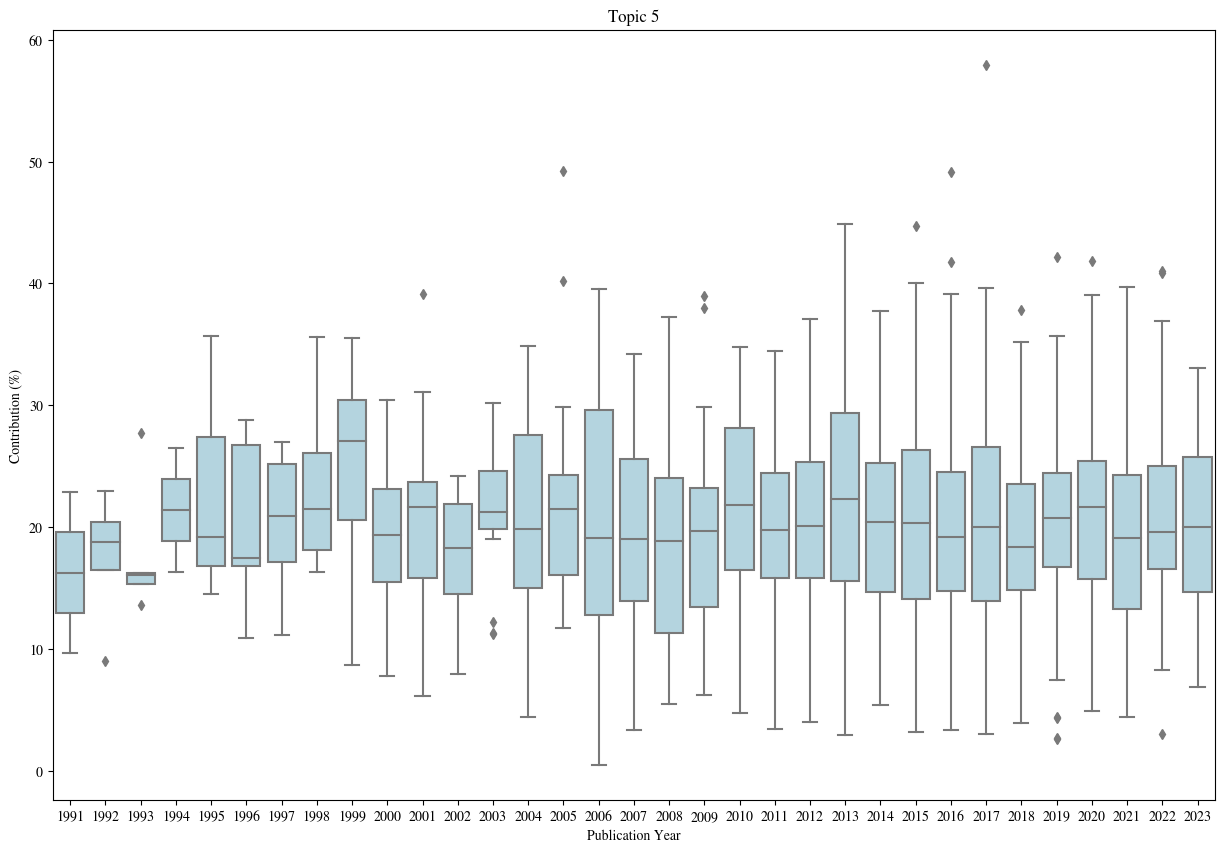

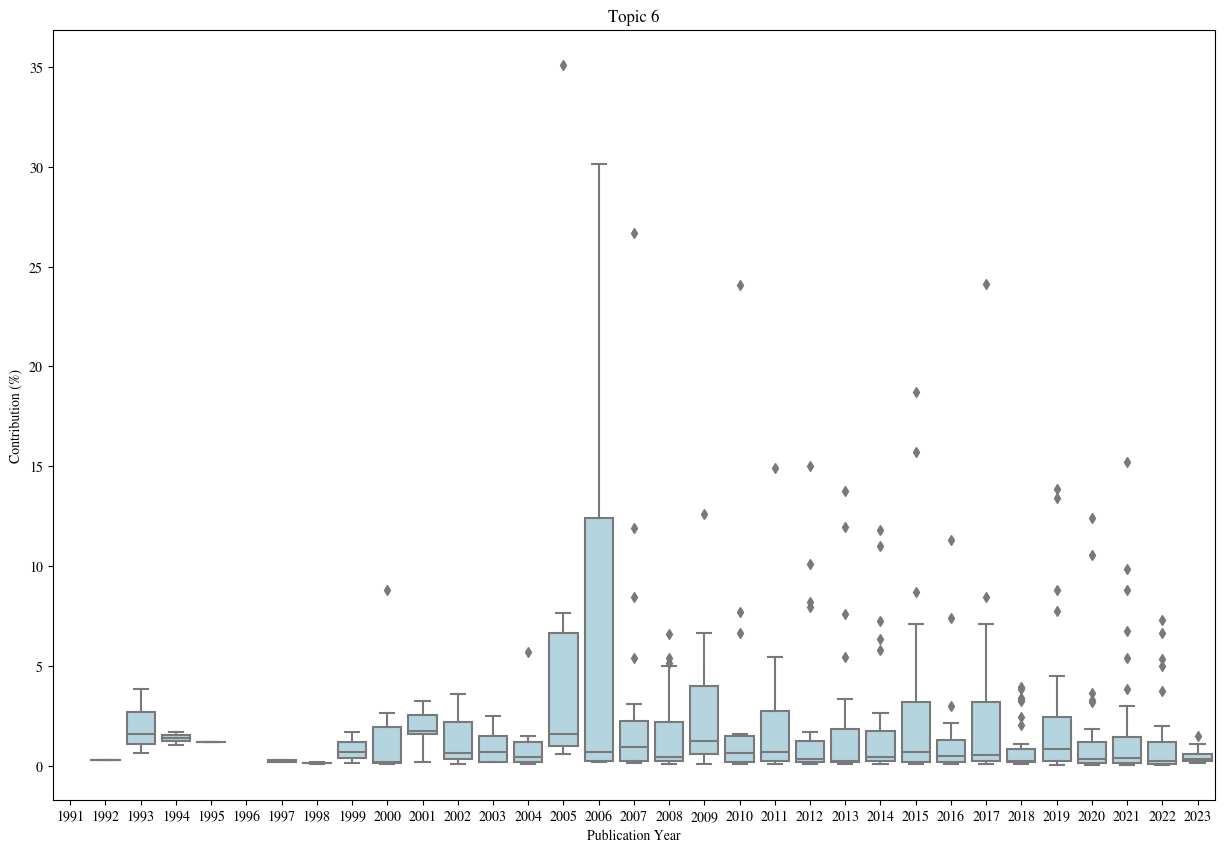

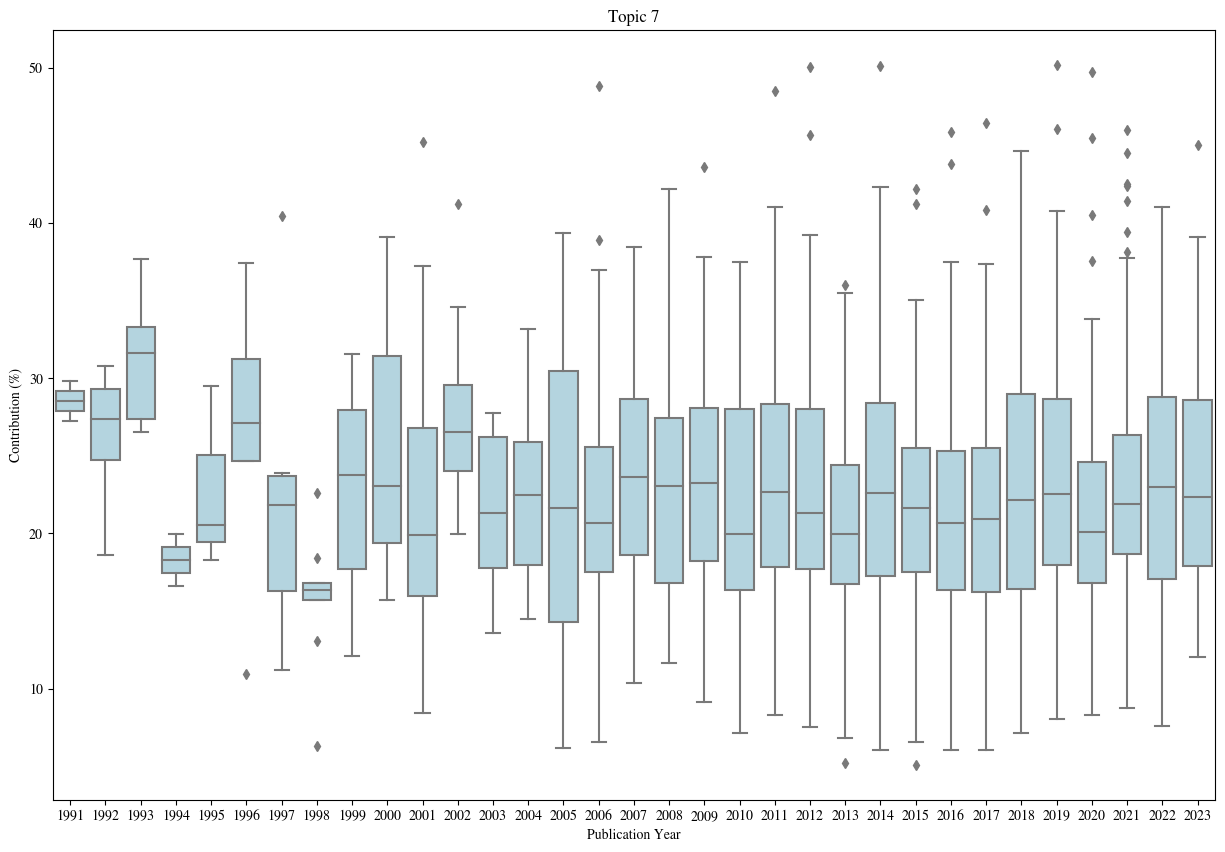

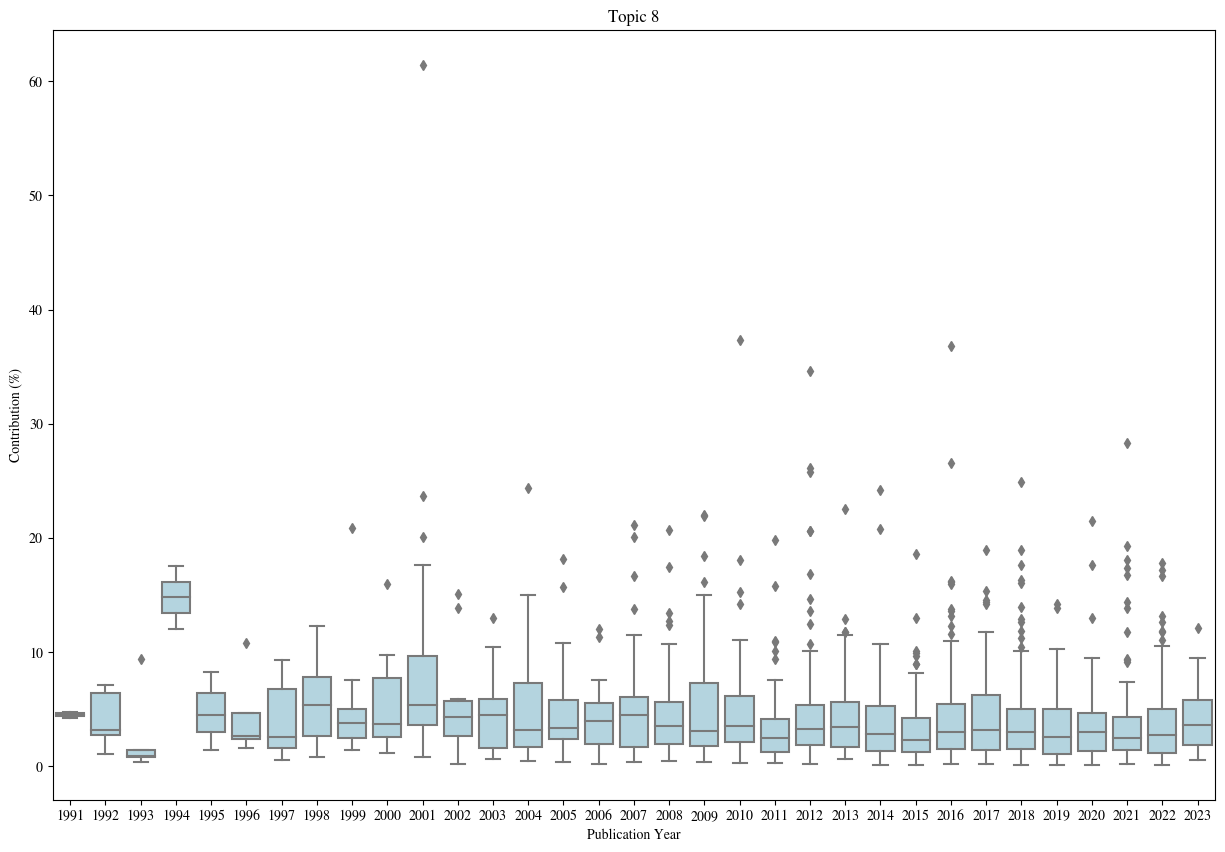

In [80]:
# Produces single boxplots for each topic
for topic in range(model.num_topics):
    plt.figure(figsize=(15, 10))
    sns.boxplot(data=df_contributions, x="pubyear", y=topic, color='lightblue')
    plt.title(f"Topic {topic+1}")
    plt.ylabel("Contribution (%)")
    plt.xlabel("Publication Year")

c:\Users\kleinow\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kleinow\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kleinow\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kleinow\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

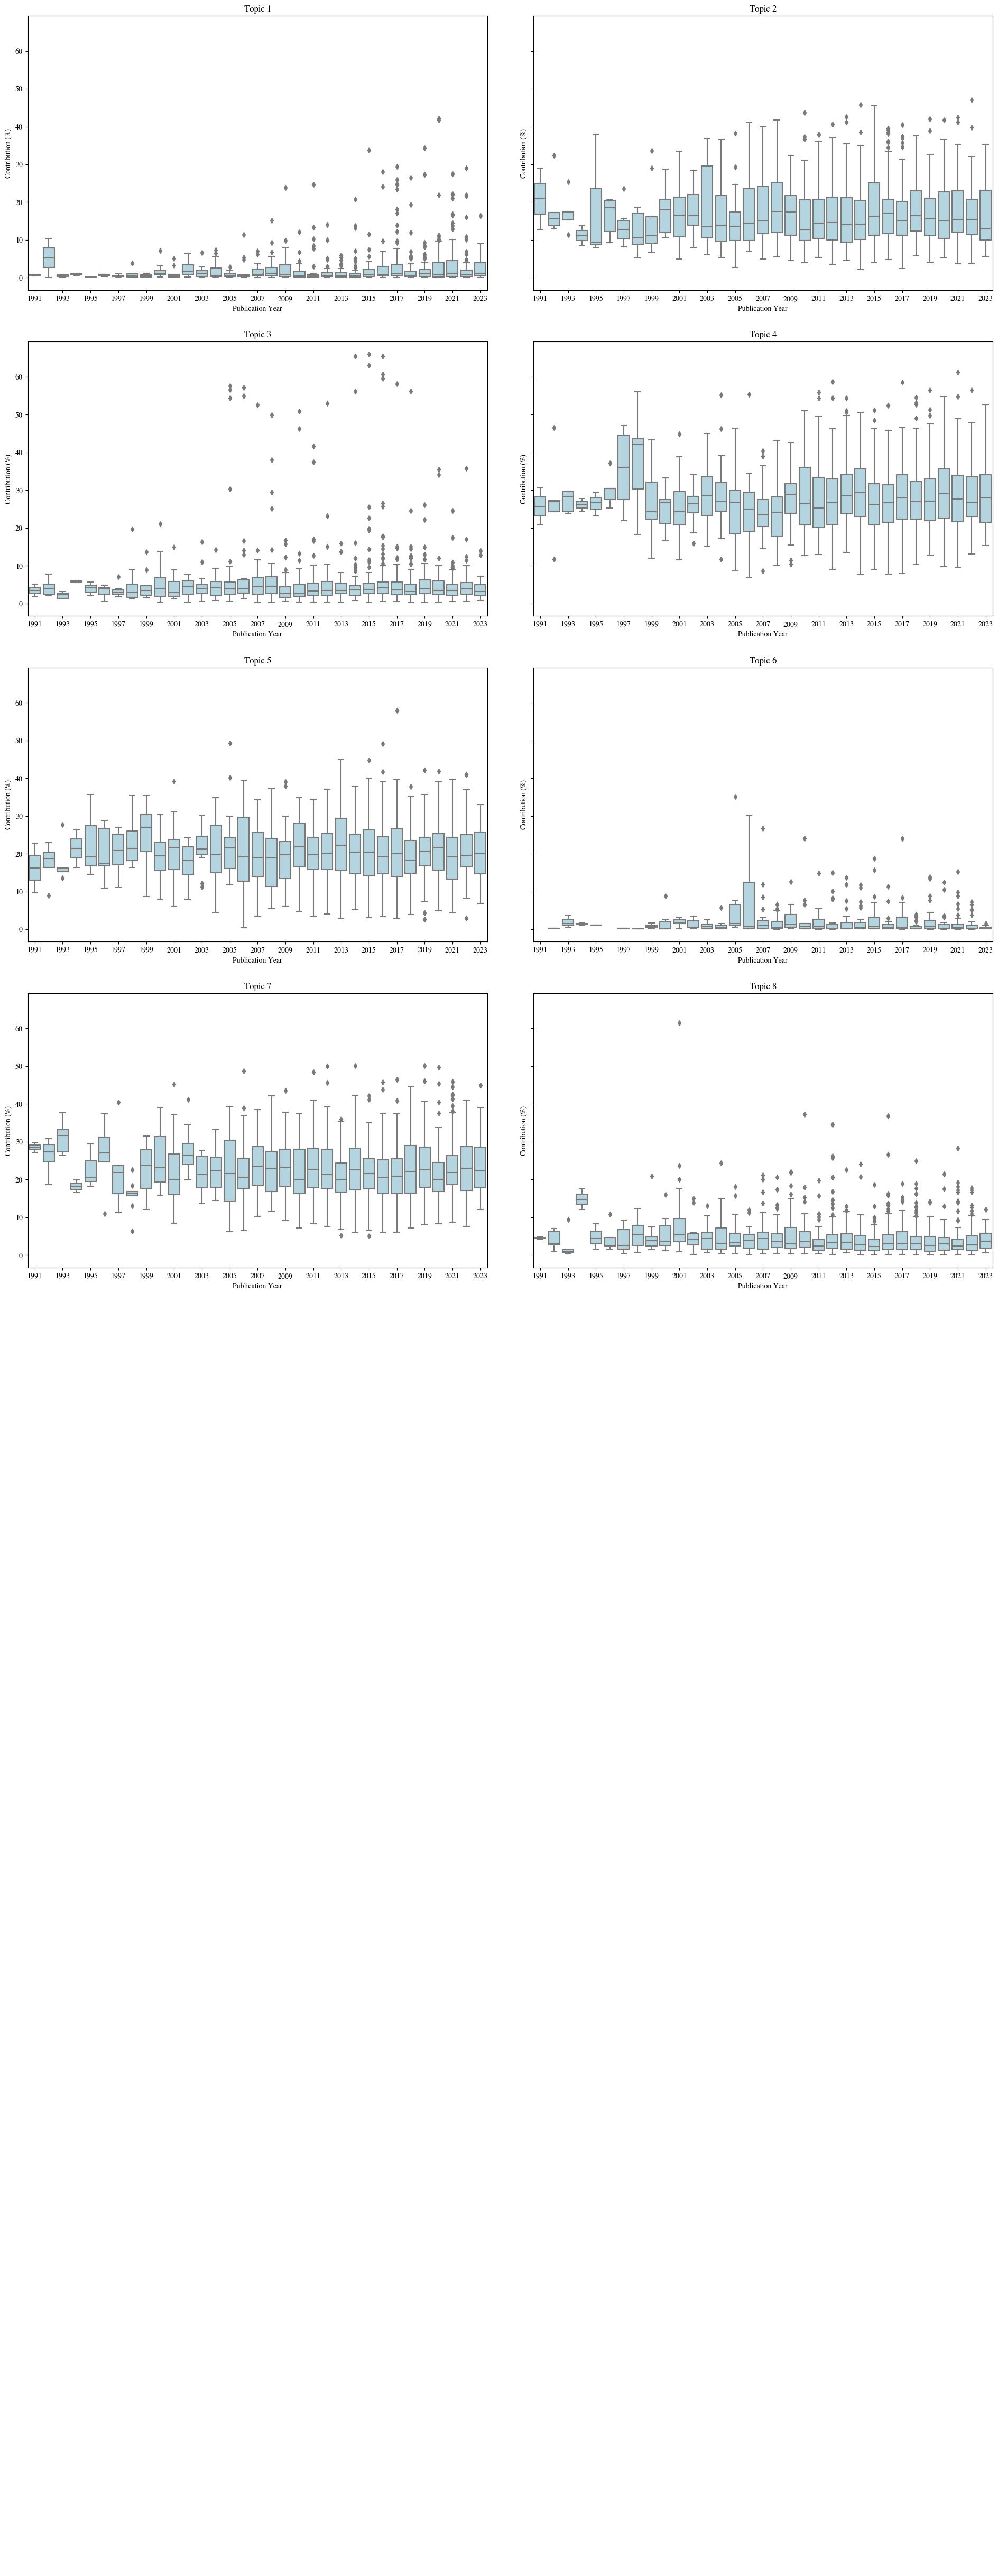

In [81]:
n_rows = 8
n_cols = 2
total_plots = n_rows * n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 50), sharey=True)
fig.tight_layout(pad=5.0)  # Add padding between subplots

for topic in range(model.num_topics):
    # Identify the row and column in the grid
    row = topic // n_cols
    col = topic % n_cols
    ax = axes[row, col]
    
    sns.boxplot(data=df_contributions, x="pubyear", y=topic, ax=ax, color='lightblue')
    ax.set_title(f"Topic {topic+1}")
    ax.set_ylabel("Contribution (%)")
    ax.set_xlabel("Publication Year")
    
    n = 2
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::n])  # show every nth tick

for i in range(model.num_topics, total_plots): # Hide the remaining subplots
    row = i // n_cols
    col = i % n_cols
    axes[row, col].axis('off')

filename = "all_boxplots_8.png"
plt.savefig(filename, dpi=300)
plt.show()
#plt.close() 

fig, axes = plt.subplots(5, 3, figsize=(20, 10))
fig.suptitle('Topic Contributions by Publication Year')

for topic, ax in enumerate(axes.ravel()):
    ax.boxplot(df_contributions[df_contributions.columns[topic]].dropna(), vert=False)
    ax.set_title(f"Topic {topic+1}")
    ax.set_yticklabels([df_contributions.columns[topic]])
    ax.set_xlabel("Contribution (%)")
    ax.set_xlim([0, 1])  # Assuming contributions are percentages between 0 and 1

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [82]:
def compute_document_topic_contribution(model, corpus):
    document_topic_contributions = []
    zero_contribution_docs = []

    for idx, doc in enumerate(corpus):
        topic_distributions = dict(model[doc][0])  # Topic distributions for the document
        total_topic_contrib = {topic: 0 for topic in range(model.num_topics)}
        
        for word_id, word_freq in doc:
            word_topic_probs = dict(model.get_term_topics(word_id, minimum_probability=0))
            
            for topic, prob in word_topic_probs.items():
                total_topic_contrib[topic] += prob * topic_distributions.get(topic, 0) * word_freq
        
        # Normalize the contribution to percentage
        total_sum = sum(total_topic_contrib.values())
        
        if total_sum == 0:  # Handle the edge case where total contribution is zero
            zero_contribution_docs.append(idx)
            total_contrib_percent = {topic: 0 for topic in range(model.num_topics)}
        else:
            total_contrib_percent = {topic: (contrib/total_sum)*100 for topic, contrib in total_topic_contrib.items()}
        
        document_topic_contributions.append(total_contrib_percent)

    return document_topic_contributions, zero_contribution_docs

contributions, zero_contrib_docs = compute_document_topic_contribution(model, corpus)

if zero_contrib_docs:
    print(f"Documents with zero total contribution: {zero_contrib_docs}")
else:
    print("No documents with zero total contribution found.")

Documents with zero total contribution: [17, 31, 35, 40, 75, 79, 80, 86, 101, 105, 109, 111, 145, 165, 190, 224, 240, 277, 291, 301, 307, 310, 311, 312, 318, 356, 384, 392, 400, 432, 436, 441, 463, 466, 518, 527, 542, 546, 586, 588, 603, 606, 631, 674, 675, 687, 697, 705, 706, 707, 708, 710, 714, 716, 720, 724, 725, 728, 731, 737, 739, 757, 759]


In [83]:
def get_normalized_topic_contributions_for_year(model, corpus, data, topic_num=0):
    yearly_contributions = {}
    
    for i, row_lists in enumerate(model[corpus]):
        year = data.iloc[i]['pubyear']
        row = row_lists[0]  # list of (topic number, topic probability) pairs
        
        for topic, prob in row:
            if topic == topic_num:
                if year not in yearly_contributions:
                    yearly_contributions[year] = {"total_prob": 0, "count": 0}
                
                yearly_contributions[year]["total_prob"] += prob
                yearly_contributions[year]["count"] += 1
                
    # average influence per document for each year
    avg_contributions = [(year, values["total_prob"] / values["count"]) for year, values in yearly_contributions.items()]
    
    return avg_contributions

all_contributions = []
for model in model_list:
    all_contributions.extend(get_normalized_topic_contributions_for_year(model, corpus, data))

# df for easier plotting
df_contributions = pd.DataFrame(all_contributions, columns=['pubyear', 'contribution'])

#plt.figure(figsize=(15, 7)) # Violins not really suitable for this visualization
#sns.violinplot(x="pubyear", y="contribution", data=df_contributions)
#plt.title("Influence of Topic 1 Over the Years")
#plt.show()

**Number of articles per topic per year**

In [84]:
groups = ['1', '2', '3', '4', '5', '6', '7', '8']#, '9', '10', 
          #'11', '12', '13', '14', '15']

In [85]:
selected_num_topics = num_of_topics[max_index]

In [86]:
table = data_with_topics.groupby(['pubyear', 'Dominant_Topic']).size()

In [87]:
data_with_topics['Dominant_Topic'].unique()

array([4, 6, 2, 3, 1, 5, 7, 0], dtype=int64)

In [88]:
table

pubyear  Dominant_Topic
1991     6                  2
1992     1                  1
         3                  1
         4                  1
         6                  2
                           ..
2022     7                  1
2023     1                  2
         3                  4
         4                  7
         6                 14
Length: 139, dtype: int64

In [89]:
years = sorted(data_with_topics.pubyear.unique())

In [90]:
counts = []
for year in years:
    specific_year = data_with_topics[data_with_topics['pubyear'] == year]
    count = []
    for topic in range(selected_num_topics):
        count.append(specific_year[specific_year["Dominant_Topic"] == topic].count().values[0])
    counts.append(count)

In [91]:
df_topic_contributions = pd.DataFrame(columns=range(model.num_topics), index=data.index)

# Fill in the dataframe with the topic contributions for each document
for i, row_lists in enumerate(model[corpus]):
    for topic_num, topic_prob in row_lists[0]:
        df_topic_contributions.at[i, topic_num] = topic_prob

# Fill NaN values with 0
df_topic_contributions.fillna(0, inplace=True)

main_papers_df = pd.DataFrame(columns=list(data.columns) + ["Topic"])

for topic in range(model.num_topics):
    idx_max = df_topic_contributions[topic].idxmax()
    main_paper = data.iloc[idx_max].copy()  # .copy() is added to prevent SettingWithCopyWarning
    main_paper["Topic"] = topic
    main_papers_df.loc[len(main_papers_df)] = main_paper

In [92]:
main_papers_df

,abstract,item_id,title_lower,pubyear,title_abs,Topic
0,"{""The analysis of sentiment contained in vast ...",WOS:000722629000006,seasonal variation in collective mood via twit...,2017,seasonal variation in collective mood via twit...,0
1,"{""Work is currently being done by a number of ...",WOS:A1995TM57300020,exploration and virtual experimentation in a l...,1995,exploration and virtual experimentation in a l...,1
2,"{""To expand our studies on accommodation in hu...",WOS:000341844800002,effects of temperature on simulated electroton...,2014,effects of temperature on simulated electroton...,2
3,"{""Detailed brain modeling has been presenting ...",WOS:000524679600058,gpu implementation of neural-network simulatio...,2019,gpu implementation of neural-network simulatio...,3
4,"{""Maximization of information transmission by ...",WOS:000228195800057,generalized bienenstock-cooper-munro rule for ...,2005,generalized bienenstock-cooper-munro rule for ...,4
5,"{""In this work, we propose a mathematical mode...",WOS:000292776200003,attentional focus modulated by mesothalamic do...,2010,attentional focus modulated by mesothalamic do...,5
6,"{""Diverse taxa use Earth's magnetic field (i.e...",WOS:000748450800001,sensation to navigation: a computational neuro...,2022,sensation to navigation: a computational neuro...,6
7,"{""This paper is concerned with the numerical s...",WOS:000169476600012,a numerical study of mixed parabolic-gradient ...,2001,a numerical study of mixed parabolic-gradient ...,7


In [93]:
latex_df = main_papers_df[["Topic", "title_lower", "pubyear"]].copy()
latex_df["Topic"] += 1  # increment topic numbers to start from 1
latex_df.rename(columns={"title_lower": "Title", "pubyear": "Publication Year"}, inplace=True)

def title_case(s):
    words = s.split()
    # Capitalize the first word and then apply custom title case for the rest
    return words[0].capitalize() + ' ' + ' '.join([word.capitalize() if word not in stop_words else word for word in words[1:]])#['of', 'and', 'in', 'the', 'for', 'on'] else word for word in words[1:]])

latex_df["Title"] = latex_df["Title"].apply(title_case)
latex_df
# Generate the LaTeX table
#latex_output = latex_df.to_latex(index=False)

#print(latex_output)

,Topic,Title,Publication Year
0,1,Seasonal Variation in Collective Mood Via Twit...,2017
1,2,Exploration and Virtual Experimentation in a L...,1995
2,3,Effects of Temperature on Simulated Electroton...,2014
3,4,Gpu Implementation of Neural-network Simulatio...,2019
4,5,Generalized Bienenstock-cooper-munro Rule for ...,2005
5,6,Attentional Focus Modulated by Mesothalamic Do...,2010
6,7,Sensation to Navigation: a Computational Neuro...,2022
7,8,A Numerical Study of Mixed Parabolic-gradient ...,2001


In [94]:
#latex_output = latex_df.to_latex(index=False) # to_latex does not work because of pandas version, but current version required to match with the other libraries
def generate_latex_table(df):
    start = "\\begin{footnotesize}\n\\begin{tabularx}{\\linewidth}{|l|X|l|}\n\\hline\n"
    header = "Topic & Title & Publication Year\\\\\n\\hline\n"

    rows = []
    for _, row in df.iterrows():
        topic = row["Topic"]
        title = row["Title"]
        year = row["Publication Year"]
        rows.append(f"{topic} & {title} & {year}\\\\\n\\hline")

    footer = "\\end{tabularx}\n\\end{footnotesize}"
    return start + header + ''.join(rows) + footer

latex_output = generate_latex_table(latex_df)
print(latex_output)

\begin{footnotesize}
\begin{tabularx}{\linewidth}{|l|X|l|}
\hline
Topic & Title & Publication Year\\
\hline
1 & Seasonal Variation in Collective Mood Via Twitter Content and Medical Purchases & 2017\\
\hline2 & Exploration and Virtual Experimentation in a Local Neuroscience Database & 1995\\
\hline3 & Effects of Temperature on Simulated Electrotonic Potentials and their Current Kinetics of Human Motor Axons at 20 Degrees C-42 Degrees C & 2014\\
\hline4 & Gpu Implementation of Neural-network Simulations Based on Adaptive-exponential Models & 2019\\
\hline5 & Generalized Bienenstock-cooper-munro Rule for Spiking Neurons that Maximizes Information Transmission & 2005\\
\hline6 & Attentional Focus Modulated by Mesothalamic Dopamine: Consequences in Parkinson's Disease and Attention Deficit Hyperactivity Disorder & 2010\\
\hline7 & Sensation to Navigation: a Computational Neuroscience Approach to Magnetic Field Navigation & 2022\\
\hline8 & A Numerical Study of Mixed Parabolic-gradient Syst

In [95]:
main_papers_df['Dominant_Topic'] = -1  # Initialize with -1, which means no dominant topic yet

# Iterate over each row in main_papers_df
for idx, row in main_papers_df.iterrows():
    # Retrieve the topic contributions for the current publication
    topic_contributions = df_topic_contributions.loc[row.name]  # row.name gives the original index of the publication in the data DataFrame
    # Identify the topic with the maximum contribution
    dominant_topic = topic_contributions.idxmax()
    # Store the dominant topic in the 'Dominant_Topic' column
    main_papers_df.at[idx, 'Dominant_Topic'] = dominant_topic

print(main_papers_df[['Topic', 'Dominant_Topic']])

  Topic  Dominant_Topic
0     0               4
1     1               6
2     2               4
3     3               6
4     4               6
5     5               4
6     6               6
7     7               2


plt.figure(figsize=(20, 10))
sns.violinplot(x="topic", y="contribution", hue="pubyear", data=df_contributions, inner="quart", palette="viridis", split=False)

# Some formatting to improve readability
plt.title("Contribution of Each Topic Over the Years")
plt.ylabel("Contribution (%)")
plt.xlabel("Topic Number")
plt.legend(title='Publication Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [96]:
#print(len(groups))
#print(max([len(c) for c in counts]))
#print(selected_num_topics)

In [97]:
#fig = plt.subplots(figsize=(10, 7))
#loop_range = min(len(groups), min([len(c) for c in counts]))
#for i in range(loop_range):
#    plt.plot(years, [c[i] for c in counts], '-o', label=f"{groups[i]}")
#plt.legend();

In [98]:
#counts

Number of publications where a topic was the most dominant one

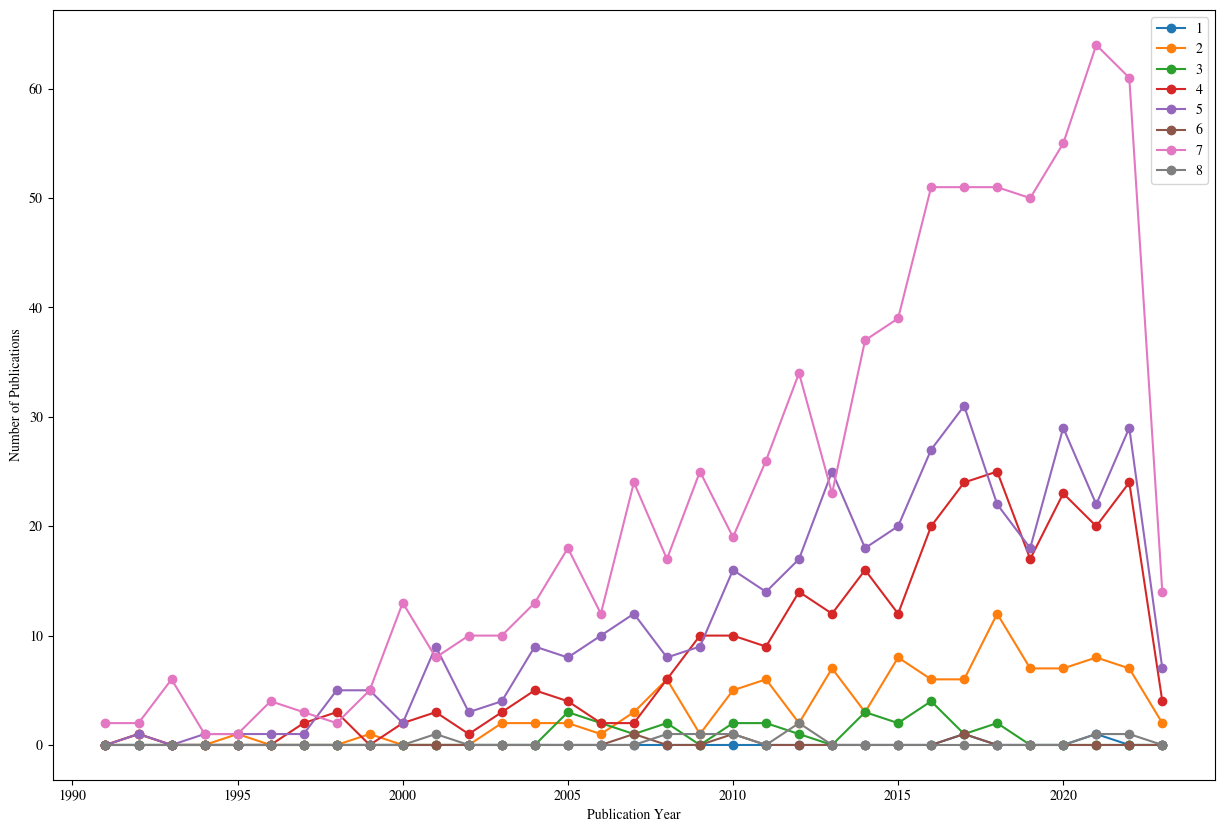

In [99]:
fig = plt.subplots(figsize=(15, 10))
for i in range(selected_num_topics):
    plt.plot(years, [c[i] for c in counts], '-o', label=f"{groups[i]}");
plt.xlabel("Publication Year");
plt.ylabel("Number of Publications");
plt.legend();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


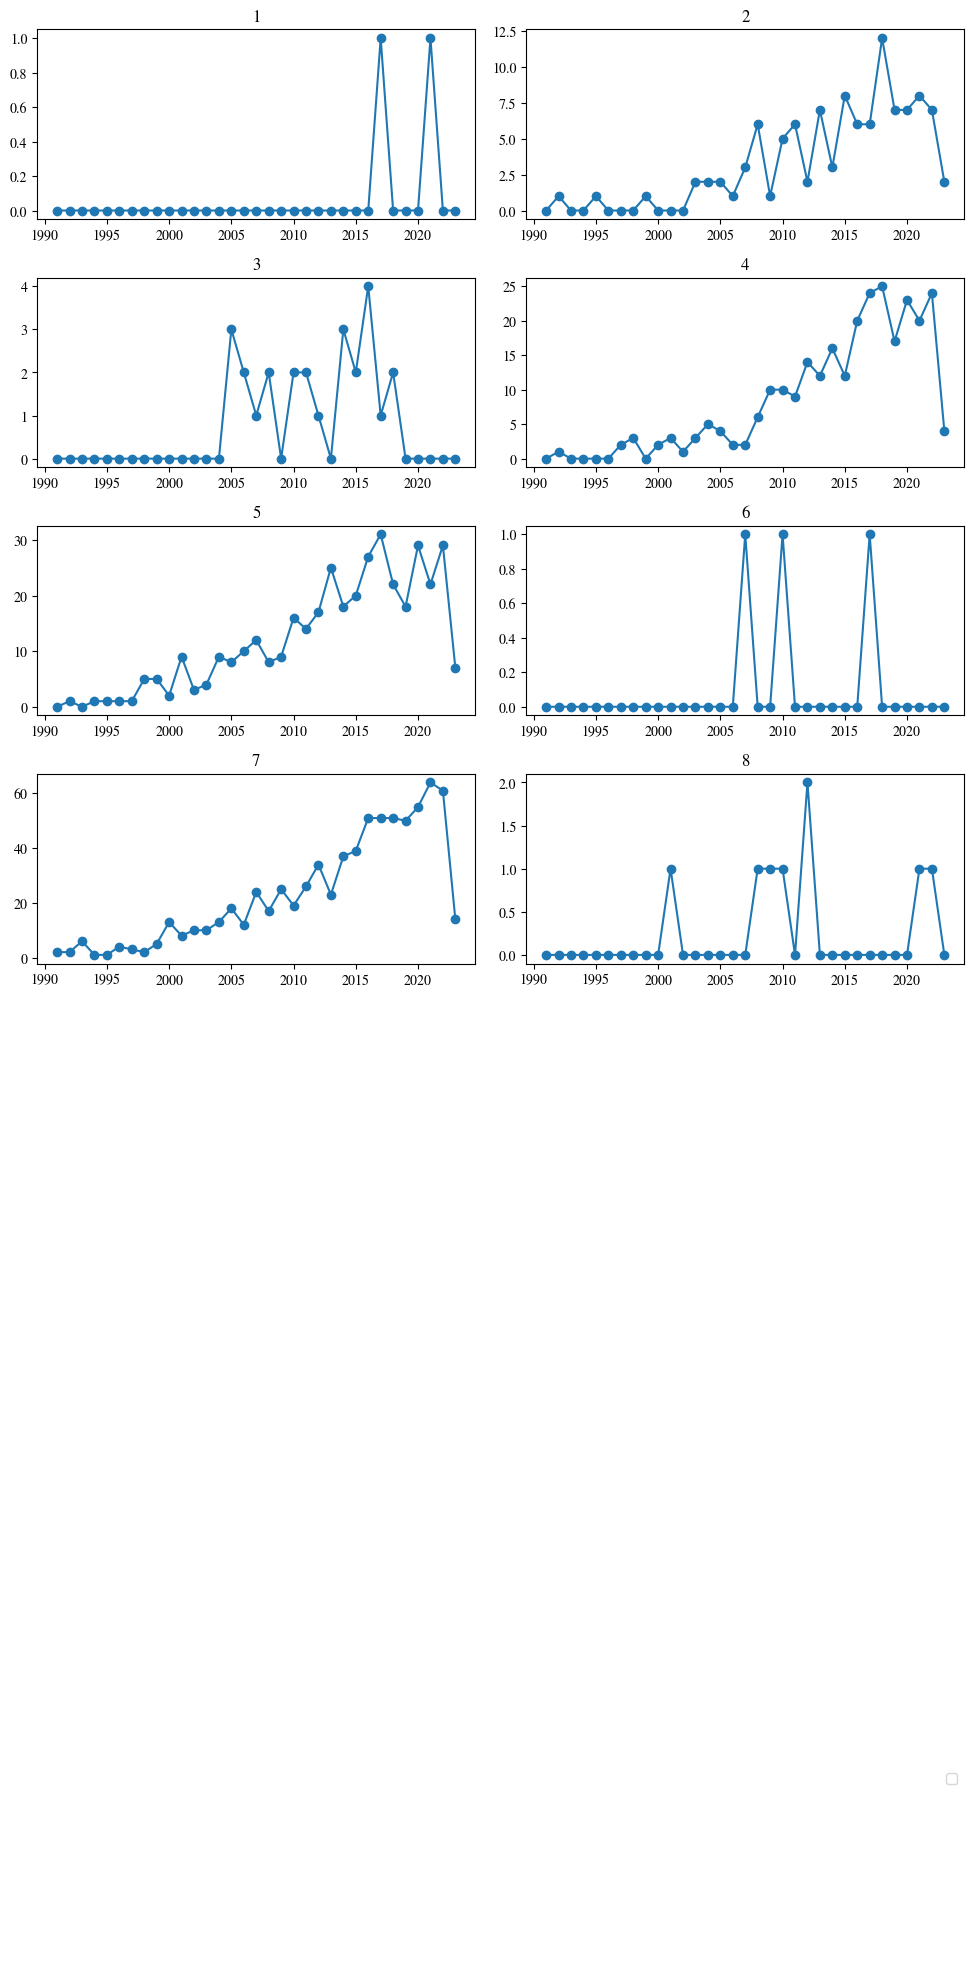

In [100]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(10, 20)) # adjust according to number of topics
flat_axes = axes.flatten()

for i in range(selected_num_topics): # slightly changed in comparison to NG with flattened axes
    flat_axes[i].plot(years, [c[i] for c in counts], '-o')
    flat_axes[i].set_title(groups[i])
flat_axes[-1].legend() # fig.legend(loc='upper right') for legend in one place
plt.tight_layout() 

for i in range(model.num_topics, total_plots): # Hide the remaining subplots
    row = i // n_cols
    col = i % n_cols
    axes[row, col].axis('off')

filename = "contribution_singles.png"
plt.savefig(filename, dpi=300)

plt.show()

In [101]:
subset_of_years = years[20:]

In [102]:
counts = []
for year in subset_of_years:
    specific_year = data_with_topics[data_with_topics['pubyear'] == year]
    count = []
    for topic in range(selected_num_topics):
        count.append(specific_year[specific_year["Dominant_Topic"] == topic].count().values[0])
    counts.append(count)

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 10))
for i in range(selected_num_topics):
    index = (int(i / 3), i % 3)
    axes[index].plot(subset_of_years, [c[i] for c in counts], '-o');
    axes[index].set_title(groups[i])
plt.tight_layout()

# for legends on last "real" plot
#if selected_num_topics < 24:
#    axes[int((selected_num_topics - 1) / 4), (selected_num_topics - 1) % 4].legend()

plt.show()

In [103]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_of_topics[max_index], 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [104]:
lda_model.save("lda_model_8_topics")
# loaded_lda_model = gensim.models.ldamodel.LdaModel.load("lda_model_15_topics") # to reload the model

In [105]:
loaded_lda_model = gensim.models.ldamodel.LdaModel.load("lda_model_15_topics")

In [106]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(loaded_lda_model, corpus, id2word, sort_topics=False) # sort_topics=False is super important, otherwise everything is sorted by proportion of topic in corpus!
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.009111 -0.377684       1        1   3.281156
1     -0.183686  0.046807       2        1   0.643232
2     -0.155896  0.056927       3        1   0.787053
3     -0.153785  0.034182       4        1   1.084254
4     -0.036432  0.046447       5        1   2.278700
5      0.297964 -0.012445       6        1  16.191206
6      0.252270  0.033251       7        1  18.506723
7     -0.139203 -0.092448       8        1   1.309519
8      0.265701 -0.111585       9        1  17.847637
9     -0.185864  0.046360      10        1   0.007856
10     0.231314  0.126329      11        1  10.874265
11     0.295862  0.097752      12        1  25.093480
12    -0.171724  0.011674      13        1   0.684830
13    -0.117976  0.048228      14        1   1.235716
14    -0.189434  0.046204      15        1   0.174372, topic_info=                Term         Freq        Total Category  logprob  loglift
19           network  2020.000000  2020.000000  Default  30.0000  30.0000
169            spike   856.000000   856.000000  Default  29.0000  29.0000
255            brain  1567.000000  1567.000000  Default  28.0000  28.0000
55             datum  1039.000000  1039.000000  Default  27.0000  27.0000
49     computational  2542.000000  2542.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
2877      electronic     0.024965     0.924210  Topic15  -9.3805   2.7403
4521        linearly     0.024877     0.921221  Topic15  -9.3841   2.7400
2429        ordinary     0.024871     0.921809  Topic15  -9.3843   2.7391
2336  simultaneously     0.024895     0.925310  Topic15  -9.3834   2.7363
2501        positive     0.024877     0.924565  Topic15  -9.3841   2.7364

[744 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
568       5  0.962825   abnormality
1320     14  0.938260       absence
1075      2  0.939451  acceleration
2179      3  0.529181    accessible
2179      6  0.453584    accessible
...     ...       ...           ...
177       7  0.443630          work
177       9  0.026096          work
177      12  0.457682          work
3254      3  0.981201      workflow
1016      6  0.988046         write

[1000 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [107]:
num_topics = lda_model.num_topics
top_terms = 30

df_terms = pd.DataFrame(columns=range(num_topics))

for topic in range(num_topics):
    terms = lda_model.show_topic(topic, top_terms)
    df_terms[topic] = [term[0] for term in terms]  # Append terms to the dataframe

df_terms.columns = [f"Topic {i+1}" for i in range(num_topics)]

df_terms

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,spike,cell,control,model,eeg,network,computational,memory
1,synaptic,signal,movement,dynamic,potential,model,brain,decision
2,time,synchrony,robot,activity,patient,use,neuroscience,reinforcement
3,plasticity,decomposition,software,neuron,extracellular,neural,model,learning
4,dependent,spectral,tool,input,similarity,datum,learn,face
5,stochastic,methodology,cns,show,nerve,method,system,specify
6,train,bold,virtual,population,membrane,neuron,approach,age
7,energy,reconstruction,development,neural,vivo,computational,process,sequence
8,event,density,research,state,case,base,study,trade
9,rule,cellular,mental,response,channel,simulation,cognitive,replay


In [108]:
def compute_relevance(lda_model, corpus, id2word, lambda_val=0, top_n=30):
    topic_terms_prob = lda_model.get_topics()  # shape: num_topics x vocabulary_size
    term_frequency = np.zeros(topic_terms_prob.shape[1])
    for doc in corpus:
        for term_id, freq in doc:
            term_frequency[term_id] += freq

    term_prob = term_frequency / term_frequency.sum()
    
    # Compute relevance
    relevance = lambda_val * topic_terms_prob + (1 - lambda_val) * (topic_terms_prob / term_prob[None, :])
    
    topics = []
    for topic_id in range(lda_model.num_topics):
        top_terms = np.argsort(-relevance[topic_id])[:top_n]
        topics.append([id2word[term_id] for term_id in top_terms])

    return pd.DataFrame(topics).transpose()

df_top_terms = compute_relevance(lda_model, corpus, id2word, lambda_val=0, top_n=30)
print(df_top_terms)

                  0               1                2               3  \
0        fascinated     microtubule           launch  nonequilibrium   
1            potent         drastic              sce       emphasise   
2       unpredicted   morphogenetic           xolotl       bilateral   
3     superconducte         ancient  bibliographical             bar   
4        suggestive     bioelectric       absolutely         silence   
5               con      patterning     bibliography             pdf   
6          computed            bank         security       vibration   
7               hot           ising        exchanged             log   
8                mw   morphogenesis    scriptability     nonlinearly   
9          singular          buffer      affectivity           verge   
10              pro           crack       coginfocom      intriguing   
11      impractical         shuffle    psychotherapy       terminate   
12    stereotypical     psychedelic         notebook      accord

In [109]:
def compute_topic_exclusivity(lda_model, topic_id):
    topic_terms = {term_id: prob for term_id, prob in lda_model.get_topic_terms(topic_id)}
    exclusivity = {}
    
    for term_id, prob in topic_terms.items():
        avg_prob_other_topics = sum([p for t, p in lda_model.get_term_topics(term_id) if t != topic_id])
        avg_prob_other_topics /= (lda_model.num_topics - 1)
        exclusivity[term_id] = prob - avg_prob_other_topics

    return sorted(exclusivity.items(), key=lambda x: x[1], reverse=True)

num_topics = lda_model.num_topics
top_terms = 30

df_terms = pd.DataFrame(columns=range(num_topics))

for topic in range(num_topics):
    exclusive_terms = compute_topic_exclusivity(lda_model, topic)
    top_exclusive_terms = exclusive_terms[:top_terms]
    df_terms[topic] = [lda_model.id2word[term_id] for term_id, _ in top_exclusive_terms]

df_terms.columns = [f"Topic {i+1}" for i in range(num_topics)]

In [110]:
df_terms

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,spike,cell,control,model,eeg,network,computational,memory
1,synaptic,signal,movement,dynamic,potential,model,brain,decision
2,time,synchrony,robot,activity,patient,use,neuroscience,reinforcement
3,plasticity,decomposition,software,input,extracellular,neural,learn,learning
4,dependent,spectral,tool,neuron,similarity,datum,system,face
5,stochastic,methodology,cns,show,nerve,method,approach,specify
6,train,bold,virtual,population,membrane,base,model,age
7,energy,reconstruction,development,state,vivo,neuron,process,sequence
8,event,density,research,response,case,simulation,study,trade
9,rule,cellular,mental,neural,channel,computational,cognitive,replay


c:\Users\kleinow\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
c:\Users\kleinow\anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
c:\Users\kleinow\anaconda3\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
c:\Users\kleinow\anaconda3\lib\site-packages\wordcloud\wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
c:\Users\kleinow\anaconda3\lib\site-pac

IndexError: index 2 is out of bounds for axis 1 with size 2

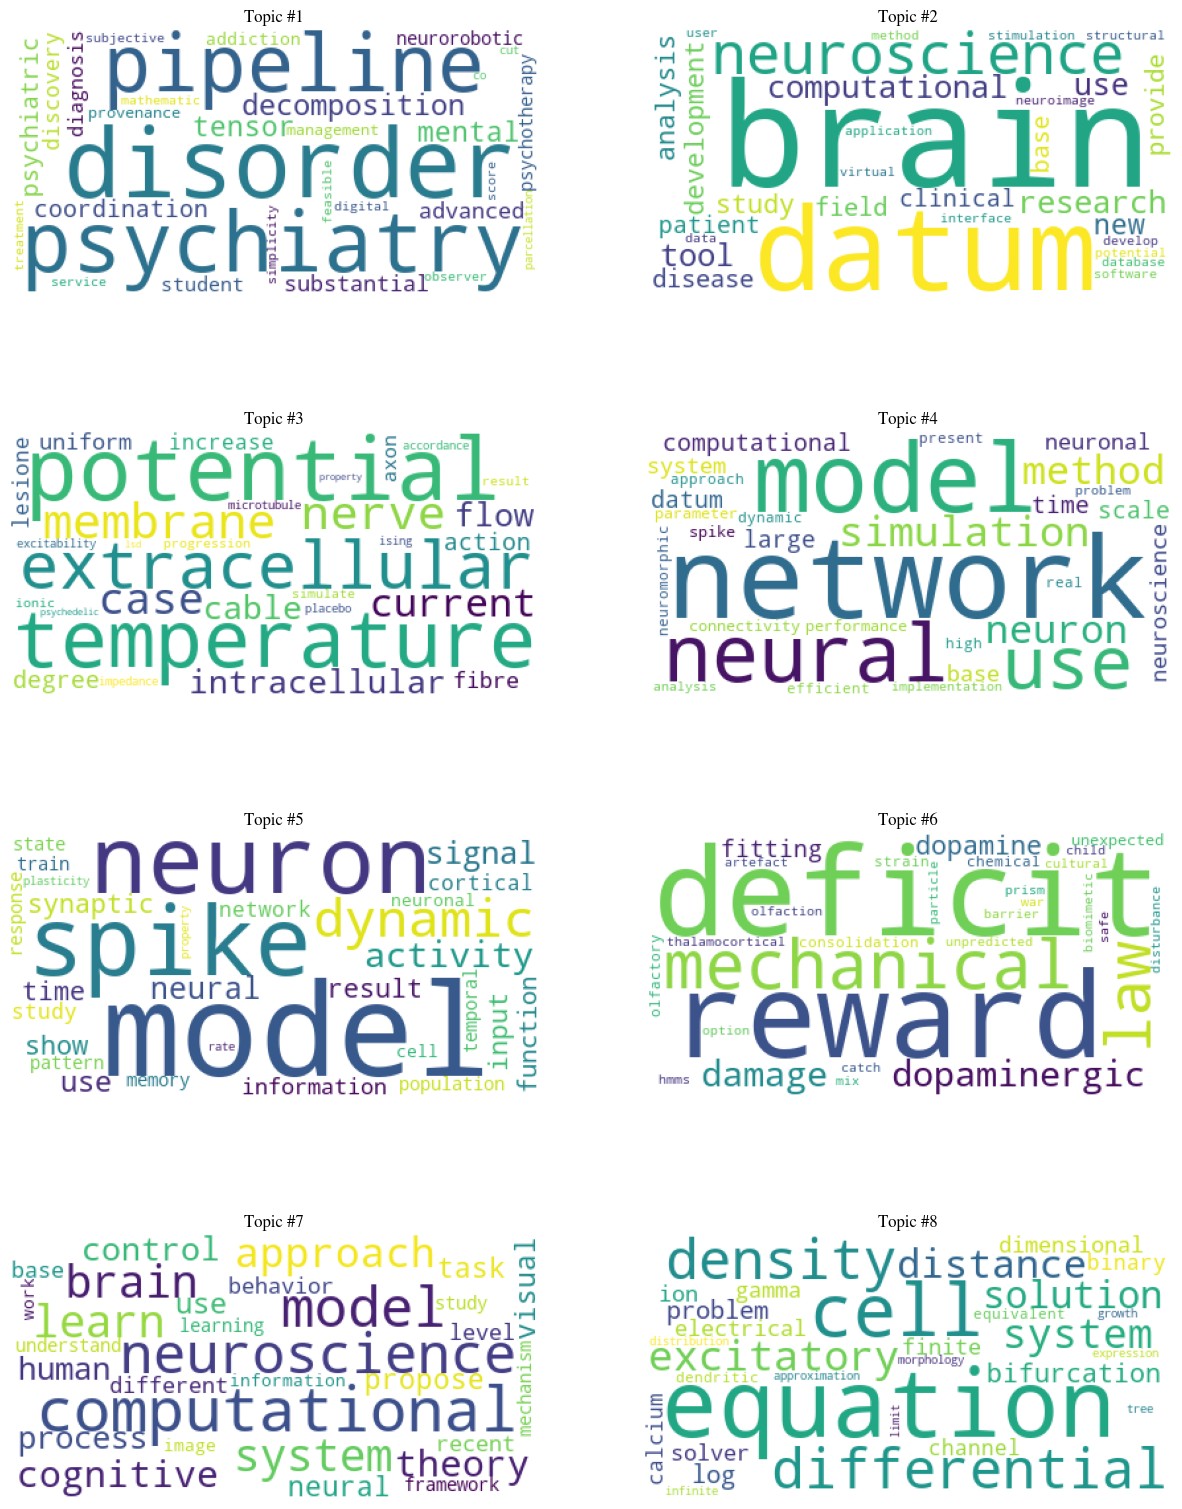

In [111]:
from wordcloud import WordCloud
num_topics = model_list[6].num_topics


fig, axes = plt.subplots(4, 2, figsize=(15, 20)) # 3x5 grid of subplots

for t in range(num_topics):
    row = t // 2
    col = t % 2
    ax = axes[row, col]
    
    wc = WordCloud(background_color='white').fit_words(dict(model_list[6].show_topic(t, 30)))
    
    ax.imshow(wc)
    ax.axis("off")
    ax.set_title("Topic #" + str(t+1))  # add 1 to the topic number

# remove too many subplots if num_topics is less than 15
for t in range(num_topics, 15):
    row = t // 3
    col = t % 3
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()
